# Movre Pischler Potentials

## Setup

In [119]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display
from IPython.display import Latex
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc

from scipy import linalg
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import Latex

import matplotlib as mpl
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
from copy import copy
from importlib import reload
import copy
import MoleculeCalculation as mol

In [120]:
reload(mol)

<module 'MoleculeCalculation' from '/Users/stevenpampel/Documents/Python/Data-Analysis-Code/Molecular Potentials/Molecules_Code_New/MoleculeCalculation.py'>

## print statements for investigation 

In [124]:
for state in mol.boStates:
    print(state)

{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'u', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g'}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u'}
{'L': 1, '|Lambda|': 1, 'S': 0, 'I_BO': 'g'}
{'L': 1, '|Lambda|': 1, 'S': 0, 'I_BO': 'u'}


### addFsRelevantStates

In [146]:
def addFsRelevantStates(boBasis):
    # Adds the states that are split by the Fs symmetry to the bare BO Basis.
    expandedBasis = []
    for state in boBasis:
        for Sigma in np.arange(-state['S'], state['S']+1,1):
            Omega = Sigma+state['|Lambda|']
            if state['|Lambda|'] != 0 and Omega==0: 
                # Pi state and Omega == 0 so Sigma = 1 and two ways of symmetrizing.
                for kappa_FS in [-1,1]:
                    newState = copy.copy(state)
                    newState.update({"|Sigma|":abs(Sigma), 'kappa_FS':kappa_FS, '|Omega|':abs(Omega)})
                    expandedBasis.append(newState)
            elif Sigma>=0:
                kappa_FS=(-1)**(1-state['|Lambda|']+state['S']-Sigma)
                newState = copy.copy(state)
                newState.update({"|Sigma|":abs(Sigma), 'kappa_FS':kappa_FS, '|Omega|':abs(Omega)})
                if newState not in expandedBasis:
                    expandedBasis.append(newState)
    return expandedBasis

a = addFsRelevantStates(mol.boStates)
for state in a:
    print(state)

{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 1}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 2}
{'L': 1, '|Lambda|': 1, 

In [118]:
def addHfsRelevantStates(boFsBasis, i_val=3/2):
    # Adds the states that are split by the HFs symmetry to the bare BO Basis.
    expandedBasis = []
    i_a = i_b = i_val
    IVals = np.arange(abs(i_a-i_b),i_a+i_b+1,1)
    for state in boFsBasis:
        for I_ in IVals:
            for Iota in np.arange(-I_, I_+1,1):
                #for Omega in [-state['|Omega|'], state['|Omega|']]:
                for Omega in [-state['|Omega|'], state['|Omega|']]:
                    Phi = Iota+Omega
                    mostUpdates = {"|Phi|":abs(Phi),'I':I_, '|Iota|':abs(Iota), 'i_a':i_a, 'i_b':i_b}
                    if Omega != 0 and Phi == 0:
                        # there are two ways of combining Omega and Iota to get Phi=0 then 
                        # and we will similarly get the symmetric and anti-symmetric superpositions.
                        for kappa_HFS in [-1,1]:
                            newState = copy.copy(state)
                            newState.update(mostUpdates)
                            newState.update({'kappa_HFS': kappa_HFS})
                            if newState not in expandedBasis:
                                expandedBasis.append(newState)
                    else:
                        newState = copy.copy(state)
                        newState.update(mostUpdates)
                        # probably want to think a moment on why using kappa_BO here
                        newState.update({ 'kappa_HFS':state['kappa_FS']*(-1)**(I_-Iota) })
                        if newState not in expandedBasis:
                            expandedBasis.append(newState)
    return expandedBasis

a = addHfsRelevantStates(mol.boStates)
# print(a)
# for state in a:
#     print(state)


### create BO Hamiltonian

In [13]:
C_3_val = mc.Rb87_C3
zero_minus_g = [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
rv = 20 * mc.a0


def get_H_BO(C3, Rv, bo_basis):
    # returns the Born Oppenheimer Hamiltonian
    # expects states to be a list of lists where the low level list has the values of L, Lambda, S,Sigma, and I_BO.
    #H_BO = np.array([[0.0 for _ in bo_basis] for _ in bo_basis])
    H_BO = np.zeros((len(bo_basis),len(bo_basis)))
    lambdaKey = "|Lambda|" if "|Lambda|" in bo_basis[0] else "Lambda"
    # the matrix is diagonal.
    for num, state in enumerate(bo_basis):
        I_BO = 1 if state["I_BO"]=="g" else -1 ###### else u
        # pv = (-1)**(state["S"]+I_BO) # should be (-1)^s*I_bo ?
        L_ = state["L"]
        H_BO[num,num] = -2*(C3/Rv**3)*(-1)**(state[lambdaKey]+state["S"]+1)*I_BO/(1+state[lambdaKey])
        # H_BO[num,num] = -pv*(3*state[lambdaKey]**2-L_*(L_+1))/Rv**3 * C3
        # print(H_BO*1e21)
    return H_BO


hbo = get_H_BO(C_3_val, rv, zero_minus_g)
print((C_3_val))

5.94492796981645e-48


### createAtomicBases

In [121]:
class multiplyableDict(dict):
    # This class exists so that I can take a basis ref and use it in np.kron()
    # to programatically get the basis ref for multi-particle systems.
    def __mul__(self, other):
        assert(type(other) == type(self))
        newDict = multiplyableDict()
        for key, value in self.items():
            key_ag = key[:-2] # remove the _x from the single particle agnostic labels
            newDict.update({key_ag+"_a": value})
        for key, value in other.items():
            key_ag = key[:-2]
            newDict.update({key_ag+"_b": value})
        return newDict

In [81]:
def createAtomicBases(lvals, svals, ivals):

    lsiBasisRef, jiBasisRef, fBasisRef = [], [], []
    for l_ in lvals:
        for s_ in svals:
            jvals = set(np.arange(abs(s_ - l_), s_ + l_+1, 1))
            for j_ in jvals:
                for i_ in ivals:
                    fVals = set(np.arange(abs(j_ - i_), j_ + i_+1, 1))
                    for f_ in fVals:
                        for m_f in np.arange(-f_,f_+1,1):
                            fBasisRef.append(multiplyableDict({"f_x":f_, "m_f_x": m_f, "j_x":j_, "l_x":l_, "s_x":s_}))
                for m_j in np.arange(-j_,j_+1,1):
                    for i_ in ivals:
                        for m_i in np.arange(-i_,i_+1,1):
                            jiBasisRef.append(multiplyableDict({"j_x":j_, "m_j_x":m_j, "l_x":l_, "s_x":s_}))    
        for m_l in np.arange(-l_,l_+1,1):
            for s_ in svals:
                for m_s in np.arange(-s_, s_+1,1):
                    for i_ in ivals:
                        for m_i in np.arange(-i_,i_+1,1):
                            lsiBasisRef.append(multiplyableDict({"l_x":l_, "m_l_x":m_l, "s_x":s_, "m_s_x":m_s}))
    return (lsiBasisRef, jiBasisRef, fBasisRef, 
            np.kron(lsiBasisRef,lsiBasisRef), np.kron(jiBasisRef,jiBasisRef), np.kron(fBasisRef,fBasisRef))

In [148]:
"""
create atomic bases
"""
# lsiBasis2Atom, jiBasis2Atom = createAtomicBases([0,1], [1/2])
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])
# print('\033[1m' + 'lsi basis' + '\033[0m',lsiBasis)
print('\033[1m' + 'lsi 2 atom basis' + '\033[0m')
# for state in jiBasis2Atom:
#     print(state)
# print('\033[1m' + 'ji 2 atom basis' + '\033[0m',jiBasis2Atom)
print(jiBasis2Atom[62])

lsi 2 atom basis
{'j_a': 1.5, 'm_j_a': 1.5, 'l_a': 1, 's_a': 0.5, 'i_a': 0, 'm_i_a': 0, 'j_b': 1.5, 'm_j_b': 0.5, 'l_b': 1, 's_b': 0.5, 'i_b': 0, 'm_i_b': 0}


### create_H_FS

In [149]:
""" 
removes i related qm numbers from jiBasis2atom and removes labels. 
Results in a 64 (number of states (NOS)) x 8 (# of QM #'s) matrix of the form
j_a, mj_a, l_a, s_a, J_b, mJ_b, l_b, s_b ]
[j_a, mj_a, l_a, s_a, J_b, mJ_b, l_b, s_b ]
...
Then calculates egeinvalues to generate 64x64 diagonal H_fs with atomic qm #'s
"""

lsiBasis2Atom, jiBasis2Atom = create_seperate_atom_bases([0,1], [1/2])
b=[]
def create_H_FS(fs_basis):
    # expects a two-particle basis, so each element of the basis should 
    # have j_a, mj_a, l_a, s_a, and J_b, mJ_b, l_b, s_b values.
    H_FS = np.zeros((len(fs_basis), len(fs_basis)))
    #j_a,mj_a,l_a,s_a,j_b,mj_b,l_b,s_b = [0 for _ in range(8)]
    names = ['j','m_j','l','s']
    # it's diagonal in this fs_basis, so only one loop.
    
    for s1num, state1 in enumerate(fs_basis): # number bases in fs_basis 0 through NOS-1
        # print(s1num,state1)
        qNums = [0 for _ in range(8)] # create (NOS)x8 matrix of zeros (for 8 quantum numbers in 2 atom ji basis (ignoring i), and NOS fs_basis states)
        for num, name in enumerate(names): # 0 j, 1 m_j, 2 l, 3 s (repeat NOS times)
            qNums[num] = state1[name+"_a"] # removes i quantum numbers from states and returns [j_a,m_j_a,l_a,s_a,0,0,0,0]
        for num, name in enumerate(names):
            qNums[num+4] = state1[name+"_b"] # fills in _b values in above array [j_a,mj_a,l_a,s_a,j_b,mj_b,l_b,s_b] 
            # print(qNums)
        # print(qNums)
        j_a,m_j_a,l_a,s_a,j_b,m_j_b,l_b,s_b = qNums # assign quantum numbers to the matrix 
        # the matrix element is A/2 (l_a . s_a + l_b . s_b), A=1
        val = 0.5 * (  j_a*(j_a+1)-l_a*(l_a+1)-s_a*(s_a+1) # calculate eigenvalues
                     + j_b*(j_b+1)-l_b*(l_b+1)-s_b*(s_b+1))
        H_FS[s1num,s1num] = val # assign eigenvalues to diagonal matrix elements 
    #     b.append(val)
    # print(b)
    # bsum=np.sum(b)
    # print(bsum)
    return H_FS

# print(jiBasis2Atom)
ft = create_H_FS(jiBasis2Atom)
print(ft)
print(np.shape(ft))

[[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0. 

### create_lsi2ToJi2_Op

In [162]:
"""
creates | j_a m_j_a i_a m_i_a >| j_b m_j_b i_b m_i_b > < l_a m_l_a s_a m_s_a i_a m_i_a |< l_b m_l_b s_b m_s_b i_b m_i_b | 
transformation matrix. The matrix elements are just clebsch Gordon coefficeints.
expects lsiBasis and jiBasis to be *two* atom bases.
"""

lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])


def create_lsi2ToJi2_Op(lsiBasis, jiBasis):
    """
    creates | j_a m_j_a i_a m_i_a >| j_b m_j_b i_b m_i_b > < l_a m_l_a s_a m_s_a i_a m_i_a |< l_b m_l_b s_b m_s_b i_b m_i_b | 
    transformation matrix. The matrix elements are just clebsch Gordon coefficeints, but you have
    to be careful to track quantum numbers carefully. 
    expects lsiBasis and jiBasis to be *two* atom bases.
    """
    assert(len(lsiBasis)==len(jiBasis))
    op = np.zeros((len(lsiBasis),len(jiBasis)))
    for lsnum, lsiState in enumerate(lsiBasis):
        for jnum, jiState in enumerate(jiBasis):
            # print(jnum, jiState)
            op[jnum,lsnum] = 1
            for suffix in ['_a','_b']:
                # there should be some repeats because of the i values in each basis
                l, m_l, s, m_s, i_lsi, m_i_lsi = [lsiState[key+suffix] for key in ['l','m_l','s','m_s', 'i', 'm_i']]
                j, m_j, jl, js, i_ji, m_i_ji = [jiState[key+suffix] for key in ['j', 'm_j', 'l', 's', 'i', 'm_i']]
                # a good example of where you really need to keep track of all the quantum numbers. 
                # needing to handle this case makes me feel like the actual clebsh gordon coef should be written as
                # <L,mL,S,mS|J,mJ,l_b,s_b> or so instead of <L,mL,S,mS|J,mJ> as it usually is written. 
                if jl != l or js != s or i_lsi != i_ji or m_i_lsi != m_i_ji:
                    op[jnum,lsnum] *= 0
                else:
                    op[jnum,lsnum] *= float(CG(l, m_l, s, m_s, j, m_j).doit())
    return op
np.set_printoptions(threshold=10)
optr = create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
# print(float(CG(0, 0, 1/2,-1/2, 1/2, 1/2).doit()))
print(optr)


[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -0.816  0.577  0.     0.     0.     0.     0.     0.    -0.     0.     0.  

### createCaseABasis_MostlySym

In [163]:
"""
Creates basis states for Hund's rule case a (E_bo>>E_fs).
|L, Lambda, I_bo, S, Sigma, Iota, i_a, i_b, Omega, Phi>
Jv and Fv are only used for rotational calculations.
does not include the planar reflection symmetry kappa_HFS. 
"""

def createCaseABasis_MostlySym(Lvals, Svals, ivals, I_BOvals=["g","u"], Jv=None, Fv=None):

    boBasisRef = []
    for I_BO in I_BOvals: # g,u
        for L_ in Lvals: # 1
            for Lambda in np.arange(-L_,L_+1,1): # -1,0,1
                for S_ in Svals: # 1/2
                    for Sigma in np.arange(-S_, S_+1,1): # 0,1
                        for i_a in ivals: # 0
                            for i_b in ivals: # 0
                                for I_ in np.arange(abs(i_b-i_a), i_b+i_a+1,1): # 0 
                                    for Iota in np.arange(-I_,I_+1,1): # 0
                                        state = multiplyableDict({"L":L_, "Lambda": Lambda, 
                                                                  "I_BO": I_BO, "S":S_, "Sigma":Sigma,
                                                                  "I":I_, "Iota":Iota, "i_a":i_a, "i_b":i_b,
                                                                  "Omega":Sigma+Lambda, "Phi": Sigma+Lambda+Iota })
                                        if Jv is not None:
                                            state.update({'J':Jv})
                                        if Fv is not None:
                                            state.update({'F':Fv})
                                        if state not in boBasisRef:
                                            boBasisRef.append(state)
    # boBasisRef = list(sorted(boBasisRef, key=lambda state: 1e5 * abs(state["Phi"]) 
    #                          + 1e2 * abs(state['Omega']) + 1 * abs(state['Sigma'])))
    return boBasisRef

caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # 
print(len(caseAMostlySymHfs))
for state in caseAMostlySymHfs:
    print(state)



24
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 1, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'u', 'S': 0, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'u', 'S': 1, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 1, 'Sigma': 1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 1, 'I_BO': 'g', 'S': 1, 'Sigma': -1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': -1, 'I_BO': 'u', 'S': 1, 'Sigma': 1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 1, 'I_BO': 'u', 'S': 1, 'Sigma': -1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 'I': 0, '

In [130]:
"""
Creates basis states for Hund's rule case a (E_bo>>E_fs).
|L, Lambda, I_bo, S, Sigma, Iota, i_a, i_b, Omega, Phi>
Jv and Fv are only used for rotational calculations.
does not include the planar reflection symmetry kappa_HFS. 
"""

def createCaseABasis_MostlySym(Lvals, Svals, ivals, I_BOvals=["g","u"], Jv=None, Fv=None):

    boBasisRef = []
    for I_BO in I_BOvals: # g,u
        for L_ in Lvals: # 1
            for Lambda in np.arange(-L_,L_+1,1): # -1,0,1
                for S_ in Svals: # 1/2
                    for Sigma in np.arange(-S_, S_+1,1): # 0,1
                        for i_a in ivals: # 0
                            for i_b in ivals: # 0
                                for I_ in np.arange(abs(i_b-i_a), i_b+i_a+1,1): # 0 
                                    for Iota in np.arange(-I_,I_+1,1): # 0
                                        state = {"L":L_, "Lambda": Lambda, 
                                                                  "I_BO": I_BO, "S":S_, "Sigma":Sigma,
                                                                  "I":I_, "Iota":Iota, "i_a":i_a, "i_b":i_b,
                                                                  "Omega":Sigma+Lambda, "Phi": Sigma+Lambda+Iota }

                                        
                                        boBasisRef.append(state)
    # boBasisRef = list(sorted(boBasisRef, key=lambda state: 1e5 * abs(state["Phi"]) 
    #                          + 1e2 * abs(state['Omega']) + 1 * abs(state['Sigma'])))
    return boBasisRef

caseAMostlySymHfs = createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # 
print(len(caseAMostlySymHfs))
for state in caseAMostlySymHfs:
    print(state)



24
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': -1, 'Phi': -1}
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 1, 'Sigma': -1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': -2, 'Phi': -2}
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 1, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': -1, 'Phi': -1}
{'L': 1, 'Lambda': -1, 'I_BO': 'g', 'S': 1, 'Sigma': 1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 1, 'Sigma': -1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': -1, 'Phi': -1}
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 1, 'Sigma': 0, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 0, 'Phi': 0}
{'L': 1, 'Lambda': 0, 'I_BO': 'g', 'S': 1, 'Sigma': 1, 'I': 0, 'Iota': 0, 'i_a': 0, 'i_b': 0, 'Omega': 1, 'Phi': 1}
{'L': 1, 'Lambda': 1, 'I_BO': 'g', 'S': 0, 'Sigma': 0, 

### caseASymFsToMostlySym

converts expanded BO states (grouped by FS symmetry) to case A states (no absolute values). Pi states become superpostion states of the form <br>
$|L, \Lambda, S, \Sigma, \Omega,\chi \rangle +\kappa_{FS} \times \delta_{\Lambda, \pm 1} |L, -\Lambda, S, -\Sigma, -\Omega , \chi \rangle $ <br>
The resulting states are assigned an index (0,1,...,23) and sign (1,-1). The index corresponds to their identical states in the case A BO basis. <br>
The sign is determined by kappa_FS from the expanded BO basis. These indices are fed into genCaseAtoLsiTransfor2 to construct MP block diagonal matrices

In [105]:
def caseASymFsToMostlySym(state, mostlySymBasis, indexes=False):
    # this is one of my weird transformations that I want to revise to be a normal matrix. 
    # I think this is the last one for the fine structure... gah of course the most tricky too.
    
    ### identify case A BO basis states (Sigma and Pi) to construct MP block diagonal matrices
    
    ## identifies Sigma (Lambda = 0) states to build Movre-Pischler bases for Omega = 0 states
    # removes absolute value signs and kappa numbers from expanded BO state
    if state['|Lambda|'] == 0 and state['|Sigma|'] == 0:
        # print('state lambda=0',state)
        stateMostlySym = {}
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS"]:
                pass
            elif key == '|Iota|':
                stateMostlySym['Iota'] = state['|Phi|']
            elif key[0] != "|": # if there are no absolute value signs
                stateMostlySym[key] = state[key]
            else:
                stateMostlySym[key[1:-1]] = 0
        
        # print(mostlySymBasis)
        # print(stateMostlySym)
        # print('index',mostlySymBasis.index(stateMostlySym))
        ## return index of stateMostlySym in mostlySymBasis, sign of state (always + since it's not a superposition state)
        if indexes:
            print([mostlySymBasis.index(stateMostlySym)], [1])
            return [mostlySymBasis.index(stateMostlySym)], [1]
        
         
        # return converted state as ket |L,Lambda,S,I_BO,Sigma,Omega>
        print('|'+''.join([str(val) for key, val in stateMostlySym.items()])+'>')
        return '|'+''.join([str(val) for key, val in stateMostlySym.items()])+'>'

    ## identifies Pi (Lambda = 1) states to build Movre-Pischler bases
    else:
        # else two state contribute
        stateMostlySym2, stateMostlySym1 = {}, {}
        # print('state lambda=1',state)
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS"]:
                pass
            elif key[0] != "|":
                stateMostlySym1[key] = state[key]
                stateMostlySym2[key] = state[key]
            elif key == "|Lambda|":
                stateMostlySym1[key[1:-1]] = state[key]
                stateMostlySym2[key[1:-1]] = -state[key] # flipping sign of Lambda due to action of kappa
            elif key == "|Sigma|":
                stateMostlySym1[key[1:-1]] = state["|Omega|"] - stateMostlySym1['Lambda']
                stateMostlySym2[key[1:-1]] = -state["|Omega|"] - stateMostlySym2['Lambda']
            elif key == "|Omega|":
                stateMostlySym1["Omega"] = state["|Omega|"]
                stateMostlySym2["Omega"] = -state["|Omega|"]
            elif key == "|Phi|":
                stateMostlySym1["Phi"] = state["|Phi|"]
                stateMostlySym2["Phi"] = -state["|Phi|"]
            elif key == "|Iota|":
                stateMostlySym1["Iota"] = state["|Phi|"]-state["|Omega|"]
                stateMostlySym2["Iota"] = state["|Phi|"]-(-state["|Omega|"])
        sign = '+' if state['kappa_FS'] == 1 else '-'
        #sign = '+' if state['kappa_BO'] == 1 else '-'
        # print('sym1',stateMostlySym1,'sym2',stateMostlySym2) 
        if indexes:
            print([mostlySymBasis.index(stateMostlySym1), mostlySymBasis.index(stateMostlySym2)], [1,1 if sign == "+" else -1])
            return [mostlySymBasis.index(stateMostlySym1), mostlySymBasis.index(stateMostlySym2)], [1,1 if sign == "+" else -1]
                ## return state numbers (indices) for superposition states to build basis (Pi states), sign of each superposotion state
        print('|'+''.join([str(val) for key, val in stateMostlySym1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateMostlySym2.items()])+'>')
        return '|'+''.join([str(val) for key, val in stateMostlySym1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateMostlySym2.items()])+'>'
    
for label, base in symmetrizedBases.items():
    print(label,base)
    for num,state in enumerate(base):
        # print(num,state)
        index= caseASymFsToMostlySym(state,caseAMostlySymHfs,indexes=False)
#         state = caseASymHfsToMostlySym(state,caseAMostlySymHfs,indexes=True)
#         # print(index,sign,state)




0+g [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
|101g0000000>
|111g-1000000>+|1-11g1000000>
0+u [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
|101u0000000>
|111u-1000000>+|1-11u1000000>
0-g [{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, '

### caseASymHfsToMostlySym

In [106]:
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # 


def getColumnState(basis, quantumNums):
    # Mostly I use bases in their dictionary form where each element has all the 
    # relevant quantum numbers readily accessibly to identify the state. But eventually
    # I need to calculate matrices which are indexed by numbers, not a list of quantum
    # numbers. This function helps facilitate the relationship between these.
    assert(len(basis[0])==len(quantumNums))
    colState = [[0] for _ in range(len(basis))]
    for num, state in enumerate(basis):
        match = True
        for qnum, val in quantumNums.items():
            if val != state[qnum]:
                match = False
        if match:
            colState[num][0] = 1
            return colState
    raise ValueError("No Match! nums were" + str(quantumNums))

# print(getColumnState(basis, quantumNums))

"dealing with absolute values when Iota is not zero"
def caseASymHfsToMostlySym(state, mostlySymBasis, indexes=False):
    # this is one of my weird transformations that I want to revise to be a normal matrix.         
    if state['|Omega|'] == 0 and state['|Iota|'] == 0:
        return caseASymFsToMostlySym(state, mostlySymBasis, indexes=indexes)
    else:
        stateMostlySym1, stateMostlySym2 = {},{} 
        for key in state.keys():
            if key in ["kappa_BO", "kappa_FS", "kappa_HFS", "|Lambda|", "|Sigma|", "|Omega|"]:
                pass
            elif key[0] != "|":
                stateMostlySym1[key] = state[key]
                stateMostlySym2[key] = state[key]
            elif key == "|Phi|":
                stateMostlySym1["Phi"] = state["|Phi|"]
            elif key == "|Iota|":
                if (state['|Iota|'] + state['|Omega|'] == state["|Phi|"]) or (state['|Iota|'] - state['|Omega|'] == state["|Phi|"]):
                    IotaSign = 1
                else:
                    IotaSign = -1
                stateMostlySym1["Iota"] = IotaSign*state["|Iota|"]
        stateMostlySym1['Omega'] = stateMostlySym1['Phi'] - stateMostlySym1['Iota']
        stateMostlySym1['Lambda'] = (1 if stateMostlySym1['Omega']>0 else -1)*state['|Lambda|']
        stateMostlySym1['Sigma'] = stateMostlySym1['Omega'] - stateMostlySym1['Lambda']
        for key in ['Phi','Iota','Omega','Lambda','Sigma']:
            stateMostlySym2[key] = -stateMostlySym1[key]  
        # Im confused about why this seems to need to involve kappa_FS to work.
        sign = '+' if state['kappa_HFS']*state['kappa_FS']*(-1)**(state['I']-state['|Iota|'])==1 else '-'
        #sign = '+' if state['kappa_HFS']*(-1)**(state['I']-state['|Iota|'])==1 else '-'
        #sign = '+' if state['kappa_HFS'] == 1 else '-'
        if indexes:
            return [mostlySymBasis.index(stateMostlySym1), mostlySymBasis.index(stateMostlySym2)], [1,1 if sign == "+" else -1]
        return '|'+''.join([str(val) for key, val in stateMostlySym1.items()])+'>'+sign+'|'+''.join([str(val) for key, val in stateMostlySym2.items()])+'>'

lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # 

# symbase = []
# for label, base in symmetrizedBases.items():
#     symbase.append(base)
# for num,state in enumerate(caseAMostlySymHfs):
#     print(num,state)
for label, base in symmetrizedBases.items():
    print('label',label)
    for num,state in enumerate(base):
        # print(num,state)
        index= caseASymHfsToMostlySym(state,caseAMostlySymHfs,indexes=False)
#         state = caseASymHfsToMostlySym(state,caseAMostlySymHfs,indexes=True)
#         # print(index,sign,state)


label 0+g
|101g0000000>
|111g-1000000>+|1-11g1000000>
label 0+u
|101u0000000>
|111u-1000000>+|1-11u1000000>
label 0-g
|100g0000000>
|111g-1000000>-|1-11g1000000>
label 0-u
|100u0000000>
|111u-1000000>-|1-11u1000000>
label 1g
label 1u
label 2g
label 2u


### caseAMostlySymToLsi_2Transf
Create transformation matrix of CG coefficients to go from case A (mostly sym) basis to 2 atom lsi basis 
$|l_{a} m_{l_a} s_{a} m_{s_a} i_{a} m_{i_a} \rangle |l_{b} m_{l_b} s_{b} m_{s_b} i_{b} m_{i_b} \rangle \langle L \Lambda S \mathbb{I}_{BO} I \mathcal{I} \Omega \Phi| \\ $
i_a and i_b included in case A (mostly sybasis in Mark's code...not sure why
point of possible confusion: caseAMostlySymHfs is evluated where caseABasis is

In [144]:
# lsiBasis2Atom, jiBasis2Atom = create_seperate_atom_bases([0,1], [1/2]) 
# only use lsi 2 atom |l_a,m_l_a,s_a,m_s_a,i_a,m_i_a,l_b,m_l_b,s_b,m_s_b,i_b,m_i_b>
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # |L, Lambda, I_bo, S, Sigma, Iota, i_a, i_b, Omega, Phi>

def caseAMostlySymToLsi_2Transf( caseABasis, lsiBasis2, verbose=False):

    # print('starting caseAMostlySymToLsi_2Transf')
    transformation = np.zeros((len(caseABasis), len(lsiBasis2)))
    # print(np.shape(transformation))
    for stateA_n, stateA in enumerate(caseABasis): # enumerate caseAmostlysSymHfs basis (8 FS states, 24 BO bases)
        # print('\033[1m' + 'state A' + '\033[0m', stateA)
        L_, Lambda = [stateA[kv] for kv in ['L','Lambda']] # extract L and Lambda values for each state in case A basis
        l_a_sa, l_b_sa = (1,0) # define atom a in p state
        S_, Sigma = [stateA[kv] for kv in ['S','Sigma']] # extract S and Sigma values for each state in case A basis
        s_a_sa, s_b_sa = (1/2,1/2) # define spin of each atom
        I_, Iota, i_a_sa, i_b_sa = [stateA[kv] for kv in ['I','Iota','i_a','i_b']] # extract '' values for each state in case A basis
        I_BO = 1 if stateA['I_BO']=='g' else -1 # g=1, u=-1
        p_ = (-1)**(S_)*I_BO # |Lambda,I_bo,k_bo,S> = (|0,0,l_a,lambda_a> + p|l_a,lamda_a,0,0>|S,Sigma>
        if verbose:
            print('pval',p_)
        for stateLsi_n, stateLsi in enumerate(lsiBasis2): # enumerate lsi two atom basis states (64 states) for each case A basis (24 states)
            # print('stateLsi',stateLsi_n,stateLsi)
            (l_a, lambda_a, l_b, lambda_b) = [stateLsi[kv] for kv in ['l_a', 'm_l_a', 'l_b', 'm_l_b']] # extract '' values from lsi 2 atom basis
            (s_a, sigma_a, s_b, sigma_b)   = [stateLsi[kv] for kv in ['s_a', 'm_s_a', 's_b', 'm_s_b']] # s_a = s_b = 1/2
            # (i_a, iota_a, i_b, iota_b)     = [stateLsi[kv] for kv in ['i_a', 'm_i_a', 'i_b', 'm_i_b']]
            
            # skips over states that don't satisfy definition of molelcular numbers
            if (S_ not in np.arange(abs(s_a-s_b), s_a+s_b+1,1) # if S not in [0,1]
                # or I_ not in np.arange(abs(i_a-i_b), i_a+i_b+1,1)
                or Lambda != lambda_a+lambda_b # remove lsi 2 atom states that don't satisfy definition of Lambda = lambda_a + lambda_b
                or Sigma != sigma_a + sigma_b # " " Sigma
                # or Iota != iota_a + iota_b# " " Iota
                or l_a == l_b): # remove if l_a = l_b
                #print('continuing...')
                # print('s',S_)
                continue 
            
#             # this is always true by definition of the states...not needed
#             d1 = 1 if s_a_sa == s_a else 0 # if s_a != 1/2
#             d2 = 1 if s_b_sa == s_b else 0 # ""
#             d3 = 1 if i_a_sa == i_a else 0
#             d4 = 1 if i_b_sa == i_b else 0
#             deltas = d1*d2*d3*d4
            
            
            oalCoef = float(CG(l_a,lambda_a,l_b,lambda_b,L_,Lambda).doit()) # find CG for OAM: =1 for every state
            # print('l_a, lambda_a, l_b, lambda_b=',(l_a, lambda_a, l_b, lambda_b))
            # print('oam coeff',oalCoef)
            spinCoef = float(CG(s_a,sigma_a,s_b,sigma_b,S_,Sigma).doit())
            # print('s_a, sigma_a, s_b, sigma_b=',(s_a, sigma_a, s_b, sigma_b))
            # print('spinCoeff',spinCoef)
            # nuclearCoef = float(CG(i_a,iota_a,i_b,iota_b,I_,Iota).doit())            
            transformation[stateA_n, stateLsi_n] = p_**(l_a)*oalCoef*spinCoef #*nuclearCoef #*deltas
        # print('transformation matrix',np.shape(transformation))
        if np.linalg.norm(transformation[stateA_n,:]) == 0:
            raise ValueError("State has zero norm!",stateA,stateA_n)
        transformation[stateA_n,:] /= np.linalg.norm(transformation[stateA_n,:]) # normalize 
    return transformation

camsl2t = caseAMostlySymToLsi_2Transf( caseAMostlySymHfs, lsiBasis2Atom, verbose=False)
for state in camsl2t:
    print(state)   

# print(np.shape(camsl2t))
# print(camsl2t[0])
# print(1/np.sqrt(2))
# {'L': 1, 'Lambda': -1, 'S': 0, 'Sigma': 0, 'Omega': -1, 'chi': 1}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': -0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': 0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': 0.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': -0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': 0.5, 'l_b': 0, 'm_l_b': 0, 's_b': 0.5, 'm_s_b': 0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'l_b': 1, 'm_l_b': -1, 's_b': 0.5, 'm_s_b': -0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': -0.5, 'l_b': 1, 'm_l_b': -1, 's_b': 0.5, 'm_s_b': 0.5}
# {'l_a': 0, 'm_l_a': 0, 's_a': 0.5, 'm_s_a': 0.5, 'l_b': 1, 'm_l_b': -1, 's_b': 0.5, 'm_s_b': -0.5}

[ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[ 0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[ 0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.  -0.5  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
[0.  0.  0.  0.  0.  0.5 0.  0.  0

### genCaseAToLsiTransform2

In [145]:
def getColumnState(basis, quantumNums):
    # Mostly I use bases in their dictionary form where each element has all the 
    # relevant quantum numbers readily accessibly to identify the state. But eventually
    # I need to calculate matrices which are indexed by numbers, not a list of quantum
    # numbers. This function helps facilitate the relationship between these.
    assert(len(basis[0])==len(quantumNums)) 
    colState = [[0] for _ in range(len(basis))] # create list of 24 [0]'s 
    for num, state in enumerate(basis): # basis is case A basis (24 states)
        # print(num,state)
        match = True
        # print(quantumNums.items())
        for qnum, val in quantumNums.items(): # quantumNums are the numbers for states in basis 
            # print(qnum,val,state[qnum])
            if val != state[qnum]:
                match = False
        if match: # indicate column state where quantumNums = state
            colState[num][0] = 1 
            return colState # returns 20 lists of length 24 containing one entry of [1] where the state matched the quantumNum
    raise ValueError("No Match! nums were" + str(quantumNums))

def genCaseAToLsiTransform2(caseABasis, lsiBasis, caseAMostlySymHfs, basisChange=None):
    # print('starting genCaseAToLsiTransform2')
    caseAToLsi = np.zeros((len(caseABasis),len(lsiBasis)))
    transf = caseAMostlySymToLsi_2Transf( caseAMostlySymHfs, lsiBasis, verbose=False)
    # print(transf)
    for staten, state in enumerate(caseABasis):  # iterate through expanded BO states grouped by FS symetry
        # print('stateN',staten, 'state',state)
        # misc.reportProgress(staten, len(caseABasis))
        indexes, signs = caseASymFsToMostlySym(state, caseAMostlySymHfs, indexes=True) # for each expanded BO state, find index and sign of case A transformed state
        # print('indexes, signs',indexes, signs)
        symFsState = 0 
        # construct the correct superposition which will preserve the symmetry of the given base. 
        # This should be only either 1 or 2 iterations in this loop.

        # for superpostions states
        if state['|Omega|'] != 0: # group indices and signs together
            indexes = [indexes[0]] #[5, 4] [1, -1] --> [5,1] 
            signs = [signs[0]] # [5, 4] [1, -1] --> [4,-1]
        for index, sign in zip(indexes,signs): # group index and sign in list of tuple [(index 1,sign 1), (index 2,sign 2)]
            # print('zip',list(zip(indexes,signs)))
            # print('index',index)
            caseAState = caseAMostlySymHfs[index] # find case A states corresponding to index
            # print('caseAState',index,caseAState)
            caseAc = getColumnState(caseAMostlySymHfs, caseAState) #find corresponding column state for case A row state
            symFsState += sign * transf.T@ caseAc # generates 64x1 matrix
        # print(caseAToLsi)
        caseAToLsi[staten, :] = symFsState[:,0] / np.sqrt(len(indexes)); # returns 16x64 matrix 
    # print(caseAToLsi)
    return caseAToLsi



caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # create case A basis {L,Lambda,I_bo,S,Sigma,Omega, Iota, Phi} 
for label, base in symmetrizedBases.items():
    print(label)
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    # print(caseAToLsi)
    
# def genCaseAToLsiTransform2(caseABasis, lsiBasis, caseAMostlySymHfs, basisChange=None):
#     # print('starting genCaseAToLsiTransform2')
#     caseAToLsi = np.zeros((len(caseABasis),len(lsiBasis)))
#     transf = caseAMostlySymToLsi_2Transf( caseAMostlySymHfs, lsiBasis, verbose=False)

#     for staten, state in enumerate(caseABasis):        
#         # misc.reportProgress(staten, len(caseABasis))
#         indexes, signs = caseASymHfsToMostlySym(state, caseAMostlySymHfs, indexes=True)
#         symFsState = 0
#         # construct the correct superposition which will preserve the symmetry of the given base. 
#         # This should be only either 1 or 2 iterations in this loop.
#         print(indexes, signs)
#         if state['|Omega|'] != 0:
#             indexes = [indexes[0]]
#             signs = [signs[0]]
#         for index, sign in zip(indexes,signs):
#             caseAState = caseAMostlySymHfs[index]
#             caseAc = getColumnState(caseAMostlySymHfs, caseAState)
#             # print(transf.shape, np.array(caseAc).shape)
#             symFsState += sign * transf.T @ caseAc
#         caseAToLsi[staten, :] = symFsState[:,0] / np.sqrt(len(indexes));
#     return caseAToLsi

0+g
[1] [1]
[5, 4] [1, 1]
0+u
[3] [1]
[7, 6] [1, 1]
0-g
[0] [1]
[5, 4] [1, -1]
0-u
[2] [1]
[7, 6] [1, -1]
1g
[17, 16] [1, 1]
[11, 9] [1, 1]
[10, 8] [1, 1]
1u
[19, 18] [1, 1]
[15, 13] [1, 1]
[14, 12] [1, 1]
2g
[21, 20] [1, 1]
2u
[23, 22] [1, 1]


In [31]:
"""
group expanded BO basis according to FS symmetry states Omega^Kfs _Ifs (projection of J along INA) 
8 possible symmetries: 0+g, 0-g, 0+u, 0-u, 1g, 1u, 2g, 2u
"""
symmetrizedBases = {}

for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega): 
            if Omega == 0:
                parityString = '+' if state['kappa_FS'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)
            
print('\033[1m' +'expanded BO basis grouped by Omega symmetry '+'\033[0m',symmetrizedBases)

expanded BO basis grouped by Omega symmetry  {'0+g': [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}], '0+u': [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}], '0-g': [{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|

In [ ]:
### Transform to basis that is diagonal for both H_bo and H_fs. 
# print(len(symmetrizedBases))
reload(mol)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u'])
H_fs_phi, H_hfs_phi = {}, {}

for label, base in symmetrizedBases.items():
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    #caseAToLsi = mol.genCaseAToLsiTransform(base, lsiBasis, caseAMostlySymHfs, basisChange=None).T
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    caseAToJi =  lsToJOp2 @ caseAToLsi
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)

In [206]:
print(np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)*1e21)

[[-1.573]]


## Start of Calculation

In [164]:
### create atomic bases with for possible single atom numbers l, s, and i (l=0,1 s=1/2  for S+P Rb87 atoms   i=0 ignoring HFS)
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])
# lsiBasis2Atom, jiBasis2Atom= create_seperate_atom_bases([0,1], [1/2])
## example output
# LsiBasis, JiBasis, FBasis, LsiBasis2Atom, JiBasis2Atom, FBasis2Atom = mol.createAtomicBases([1], [0], [0])
# print('\033[1m' + 'lsi basis' + '\033[0m',LsiBasis)
# print('\033[1m' + 'lsi 2 atom basis' + '\033[0m',LsiBasis2Atom)

### Define constants
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
print(DeltaVal)
C_3_val = mc.Rb87_C3
# C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)
print(mc.Rb87_D2LineFrequency)
print(mc.Rb87_D1LineFrequency)
print(C_3_val)

4.7197635548748796e-21
384230484468500.0
377107463500000.0
5.94492796981645e-48


In [134]:
### Define operators
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom) # creates diagonal 64x64 H_fs
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3 # 2*Delta/3 = A_FS 
lsToJOp2 = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom) # creates 64x64 ls to j transformation matrix (matrix of CG coefficients)

# print(lsToJOp2)

In [133]:
### Define operators
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom) # creates diagonal 64x64 H_fs
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3 # 2*Delta/3 = A_FS 
lsToJOp2 = create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom) # creates 64x64 ls to j transformation matrix (matrix of CG coefficients)

# print(lsToJOp2)

5120
868.824793630042


## Create Symmetrized Fine Structure Hamiltonians

In [136]:
### add fs qm numbers |Sigma|, Kappa_FS, |Omega| to BO basis (L, Lambda, S, I_BO, kappa_BO)
expandedBOBasis = mol.addFsRelevantStates(mol.boStates)

print('\033[1m' + 'BO states' + '\033[0m')
for state in mol.boStates:
    print(state)
print('')
print('\033[1m' +'expanded BO states (case A symmetrized)'+ '\033[0m')
grouped = []
for state in expandedBOBasis:
    grouped.append(state)
    print(state)
print(len(expandedBOBasis))

BO states
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'u', 'kappa_BO': 1}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g'}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u'}
{'L': 1, '|Lambda|': 1, 'S': 0, 'I_BO': 'g'}
{'L': 1, '|Lambda|': 1, 'S': 0, 'I_BO': 'u'}

expanded BO states (case A symmetrized)
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|

In [138]:
"""
for hfs code. Include total nuclear sping (Iota)," " along INA, single nuclear spin (i_a,b), 
and total ang. momentum along INA (Phi = Omega + Iota) 
"""
print('\033[1m' +'expanded BO basis states with nuclear spin '+'\033[0m')
for state in expandedBOBasis: 
    state.update({'L':1,'|Iota|':0,'I':0,'i_a':0,'i_b':0,'|Phi|':state['|Omega|'], 'kappa_HFS':state['kappa_FS']})
    # print(state)

print(len(expandedBOBasis))

expanded BO basis states with nuclear spin 
16


In [139]:
"""
group expanded BO basis according to FS symmetry states Omega^Kfs _Ifs (projection of J along INA) 
8 possible symmetries: 0+g, 0-g, 0+u, 0-u, 1g, 1u, 2g, 2u
"""
symmetrizedBases = {}

for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega): 
            if Omega == 0:
                parityString = '+' if state['kappa_FS'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)
            # print(symmetrizedBases[symmetryLabel])
            
print('\033[1m' +'expanded BO basis grouped by fine structure symmetry '+'\033[0m')
# print(len(symmetrizedBases['0+g']))
for label, state in symmetrizedBases.items():
    print(label,state)


expanded BO basis grouped by fine structure symmetry 
0+g [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
0+u [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
0-g [{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iot

### calculate H_fs

In [140]:
# create Movre-P matrix for each symmetrized state
reload(mol)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # create case A basis {L,Lambda,I_bo,S,Sigma,Omega, Iota, Phi} 
# lsiBasis2Atom, jiBasis2Atom= create_seperate_atom_bases([0,1], [1/2])
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom) # creates diagonal 64x64 H_fs
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3 # 2*Delta/3 = A_FS 
lsToJOp2 = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom) # creates 64x64 ls to j transformation matrix (matrix of CG coefficients)
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items(): # iterate through expanded BO basis grouped by FS symmetry (symmetrized case A basis - 16 bases)
    # print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    # print(base)
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T # generates 64 x len(FS_state) matrix 
    caseAToJi =  lsToJOp2 @ caseAToLsi # transform caseA_lsi into j basis (64x64)*(64*len(FS_state)) = 64xlen(FS_state) matrix
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * DeltaVal / 3)
    # (len(FS_state)x64)*(64x64)*(64xlen(FS_state)) = len(FS_state)xlen(FS_state) matrix + energy offset to define zero point

[1] [1]
[5, 4] [1, 1]
[3] [1]
[7, 6] [1, 1]
[0] [1]
[5, 4] [1, -1]
[2] [1]
[7, 6] [1, -1]
[17, 16] [1, 1]
[11, 9] [1, 1]
[10, 8] [1, 1]
[19, 18] [1, 1]
[15, 13] [1, 1]
[14, 12] [1, 1]
[21, 20] [1, 1]
[23, 22] [1, 1]


In [141]:
for key, matrix in H_fs_phi.items():
    print(key, matrix*1e21)
    # print(key,np.linalg.eigvals(matrix)/(1e-9*mc.h))
# print(np.sqrt(2)/3*DeltaVal*1e21)
print(E_FS_5P12_5P32 / 3)


0+g [[-1.573  2.225]
 [ 2.225 -3.147]]
0+u [[-1.573  2.225]
 [ 2.225 -3.147]]
0-g [[-1.573 -2.225]
 [-2.225 -3.147]]
0-u [[-1.573 -2.225]
 [-2.225 -3.147]]
1g [[-1.573  1.573  1.573]
 [ 1.573 -1.573 -1.573]
 [ 1.573 -1.573 -1.573]]
1u [[-1.573  1.573  1.573]
 [ 1.573 -1.573 -1.573]
 [ 1.573 -1.573 -1.573]]
2g [[-0.]]
2u [[-0.]]
1.5732545182916265e-21


In [75]:
# create Movre-P matrix for each symmetrized state
reload(mol)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u']) # create case A basis {L,Lambda,I_bo,S,Sigma,Omega, Iota, Phi} 
lsiBasis2Atom, jiBasis2Atom= create_seperate_atom_bases([0,1], [1/2])
fsOperator_unitless = create_H_FS(jiBasis2Atom) # creates diagonal 64x64 H_fs
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3 # 2*Delta/3 = A_FS 
lsToJOp2 = create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom) # creates 64x64 ls to j transformation matrix (matrix of CG coefficients)
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items(): # iterate through expanded BO basis grouped by FS symmetry (symmetrized case A basis - 16 bases)
    # print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    # print(base)
    caseAToLsi = genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T # generates 64 x len(FS_state) matrix 
    caseAToJi =  lsToJOp2 @ caseAToLsi # transform caseA_lsi into j basis (64x64)*(64*len(FS_state)) = 64xlen(FS_state) matrix
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * DeltaVal / 3)
    # (len(FS_state)x64)*(64x64)*(64xlen(FS_state)) = len(FS_state)xlen(FS_state) matrix + energy offset to define zero point

5120
868.8247936300421
[1] [1]
[5, 4] [1, 1]
[3] [1]
[7, 6] [1, 1]
[0] [1]
[5, 4] [1, -1]
[2] [1]
[7, 6] [1, -1]


In [76]:
for key, matrix in H_fs_phi.items():
    print(key, matrix*1e21)
    # print(key,np.linalg.eigvals(matrix)/(1e-9*mc.h))
# print(np.sqrt(2)/3*DeltaVal*1e21)
print(E_FS_5P12_5P32 / 3)


0+g [[13.897 15.537]
 [15.537 10.872]]
0+u [[13.897 15.537]
 [15.537 10.872]]
0-g [[-1.835 -1.71 ]
 [-1.71  -0.384]]
0-u [[-1.835 -1.71 ]
 [-1.71  -0.384]]
1g [[ 3.671  5.585  1.135]
 [ 5.585  3.601 -1.573]
 [ 1.135 -1.573 -2.027]]
1u [[ 3.671  5.585  1.135]
 [ 5.585  3.601 -1.573]
 [ 1.135 -1.573 -2.027]]
2g [[-0.]]
2u [[-0.]]
1.5732545182916265e-21


In [11]:
# print((C_3_val/a**3 - 2*DeltaVal/3)*1e21)
print(-DeltaVal/3)
print(-np.sqrt(2)*DeltaVal/3)
print(-2 * DeltaVal / 3)
print(-1/2* 2 * E_FS_5P12_5P32 / 3)
print((np.sqrt(2)*DeltaVal/3)*1e21)
print(2.225/-1.573)
print(2.2249/-3.14)
print((2.225/-1.573)/2)

-1.5732545182916265e-21
-2.2249178768327687e-21
-3.146509036583253e-21
-1.5732545182916265e-21
2.2249178768327686
-1.4144945963127782
-0.7085668789808917
-0.7072472981563891


## Results

[{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
[{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}]
[{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}]


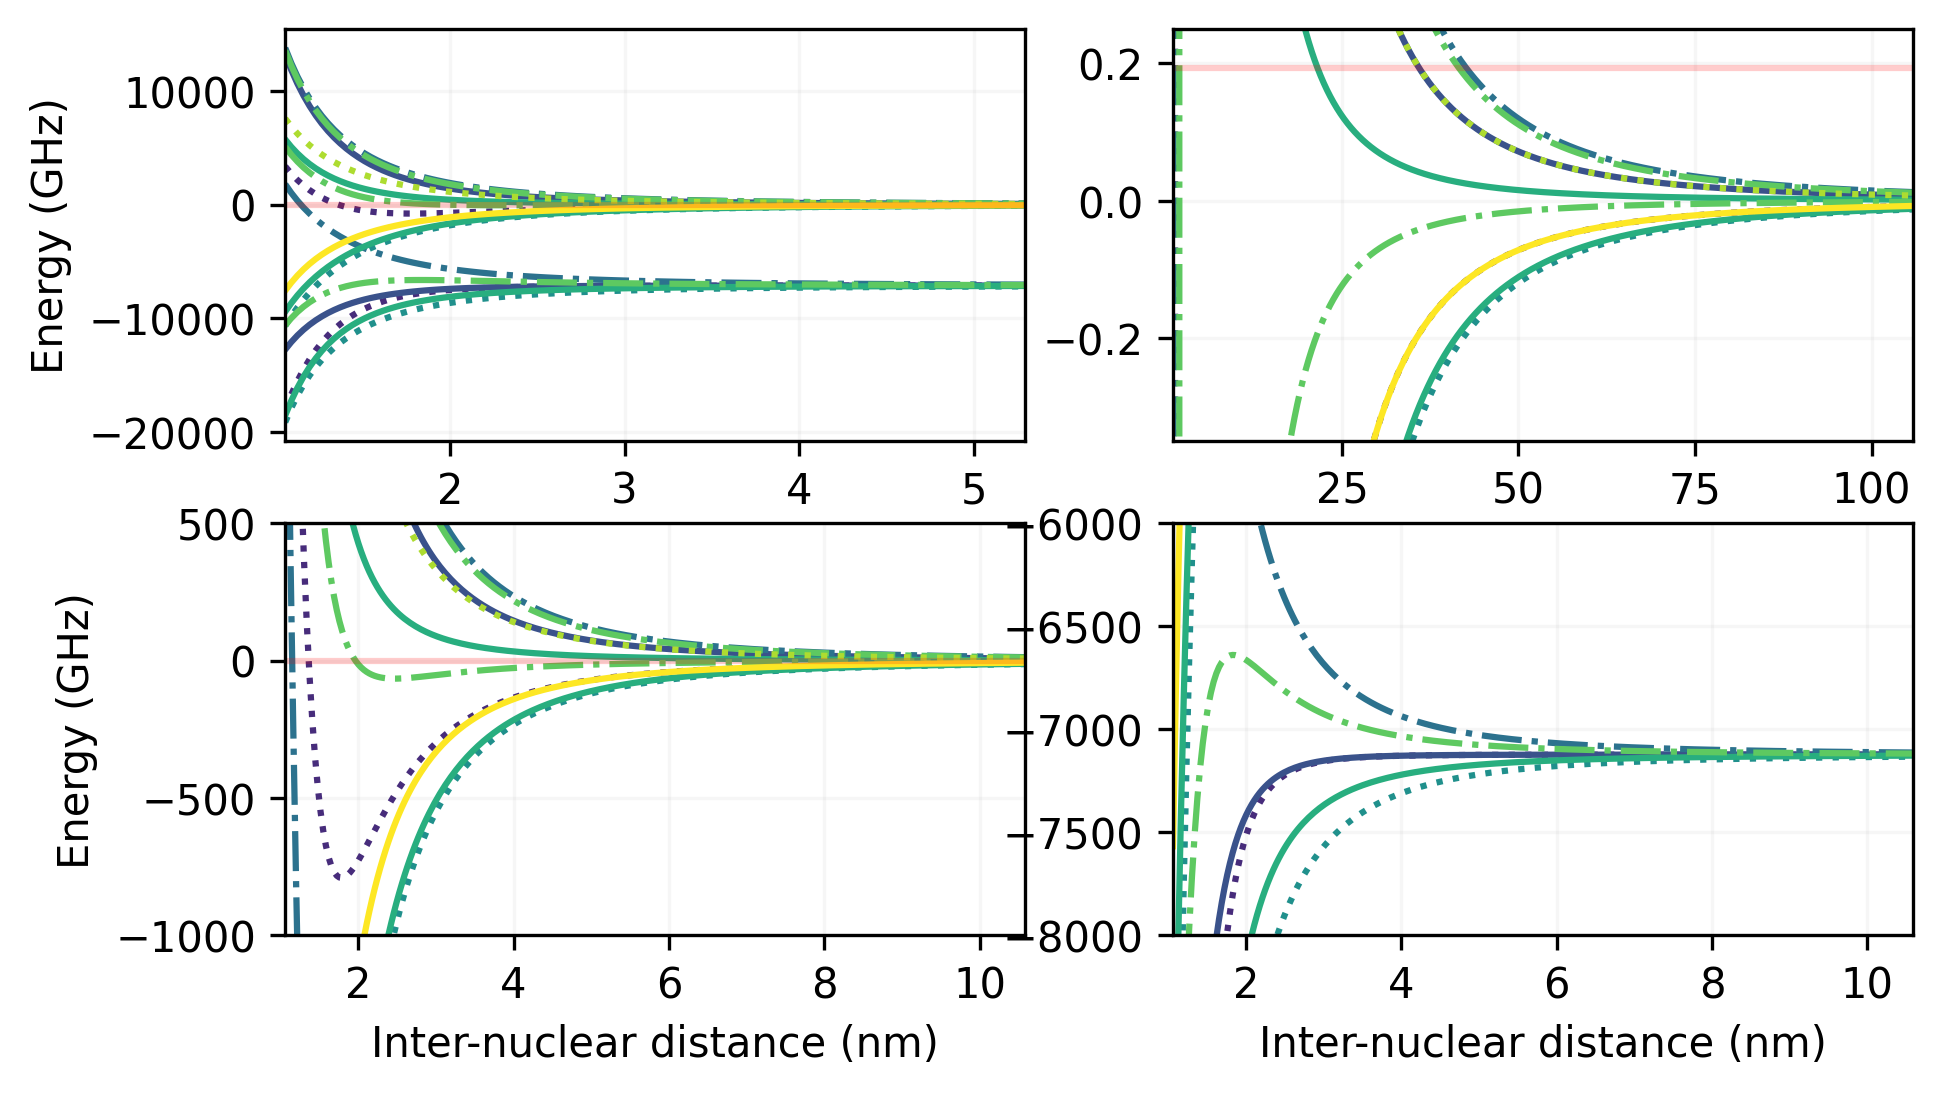

In [142]:
mpl.rcParams['figure.dpi']=300
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    print(basis)
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    
    #ax.set_xlabel('Inter-nuclear distance (nm)')
    #ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[1,0].set_xlabel('Inter-nuclear distance (nm)')
axs[1,1].set_xlabel('Inter-nuclear distance (nm)')
axs[0,0].set_ylabel('Energy (GHz)')
axs[1,0].set_ylabel('Energy (GHz)')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
#axs[0,0].legend(ncol=5,fontsize=8)
#axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
#axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
#axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)www

### Direct calculation of Movre-Pischler Potentials

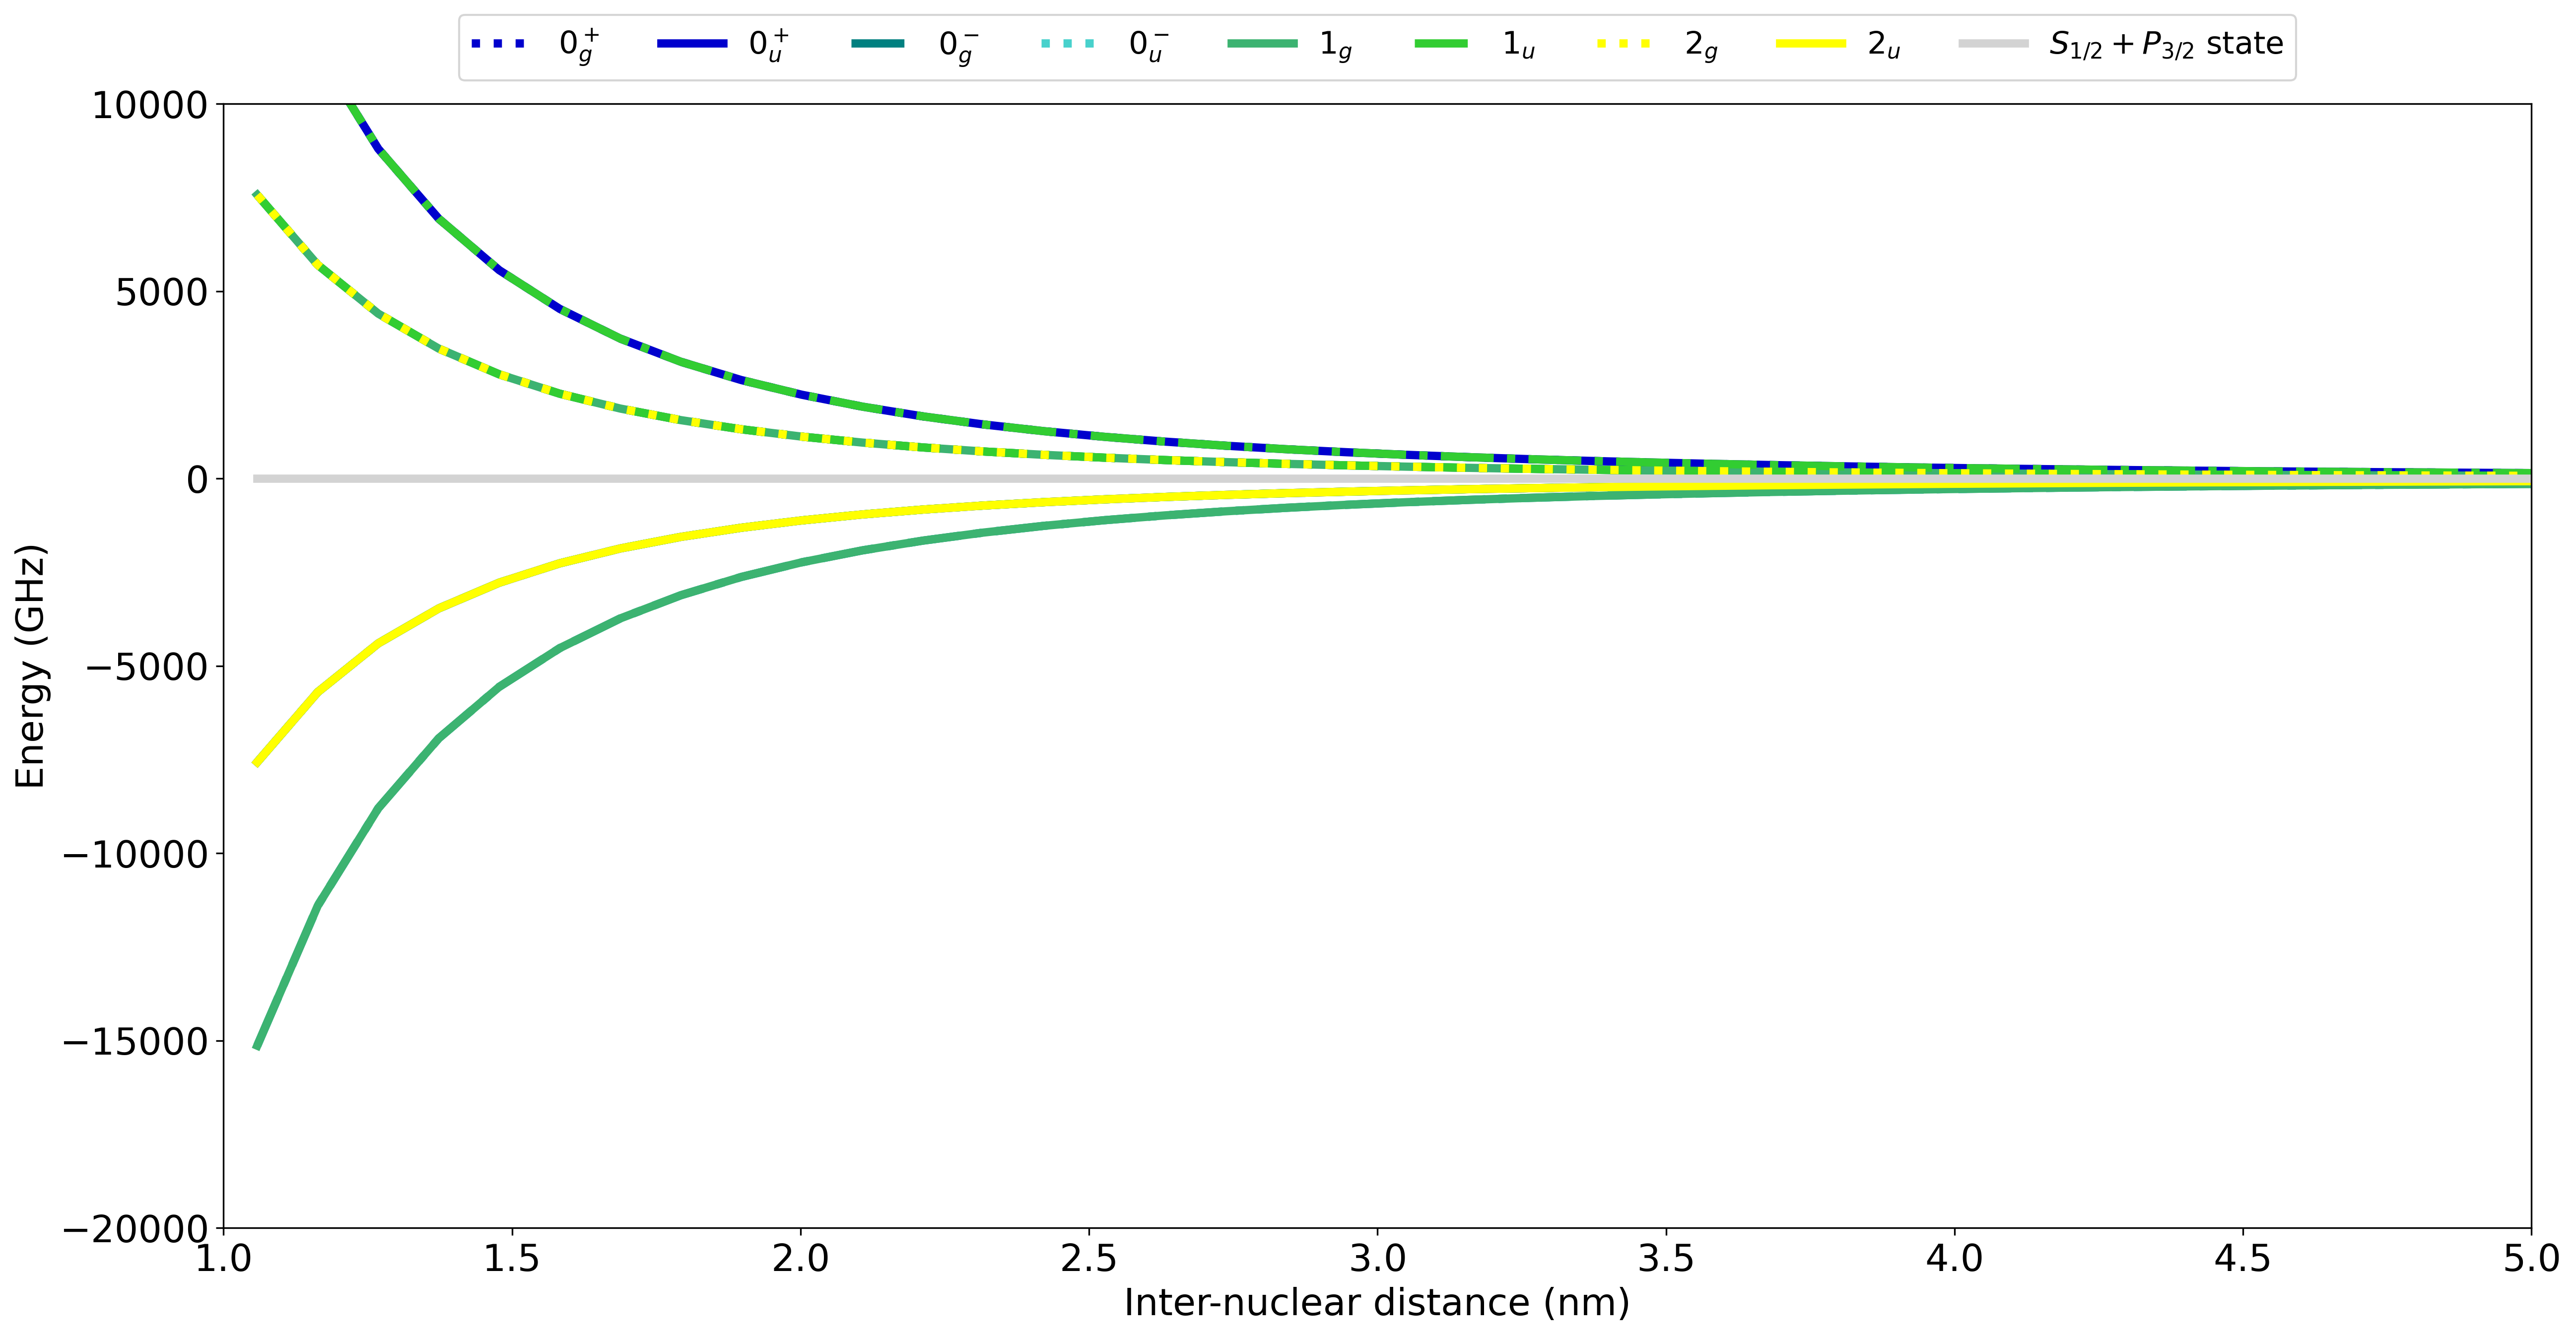

In [31]:
Rval = np.linspace( 20 * mc.a0, 2000 * mc.a0, 1000 )

def Extract1(e1):
    return [item[0] for item in e1]

def Extract2(e2):
    return [item[1] for item in e2]

def Extract3(e3):
    return [item[2] for item in e3]

# 0+g
Htot1 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot1.append(w*1e-9/mc.h)

Htot1_list = list(map(list,Htot1))
H1_e1 = Extract1(Htot1_list)
H1_e2 = Extract2(Htot1_list)

# 0+u
Htot2 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3, np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h)
    
Htot2_list = list(map(list,Htot2))
H2_e1 = Extract1(Htot2_list)
H2_e2 = Extract2(Htot2_list)

# 0-g
Htot3 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot3.append(w*1e-9/mc.h);
    
Htot3_list = list(map(list,Htot3))
H3_e1 = Extract1(Htot3_list)
H3_e2 = Extract2(Htot3_list)
# print(H1_e2)
# print(DeltaVal)

# 0-u
Htot4 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, -np.sqrt(2)*DeltaVal/3, -np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot4.append(w*1e-9/mc.h)
    
Htot4_list = list(map(list,Htot4))
H4_e1 = Extract1(Htot4_list)
H4_e2 = Extract2(Htot4_list)



# 1g    
Htot5 = []
for a in Rval:
    H = [[C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3], [-DeltaVal/3, -C_3_val/a**3 - DeltaVal/3, DeltaVal/3],\
         [DeltaVal/3, DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot5.append(w*1e-9/mc.h)
    
Htot5_list = list(map(list,Htot5))
H5_e1 = Extract1(Htot5_list)
H5_e2 = Extract2(Htot5_list)
H5_e3 = Extract3(Htot5_list)

# 1u    
Htot6 = []
for a in Rval:
    H = [-C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3, -DeltaVal/3, C_3_val/a**3 - DeltaVal/3, DeltaVal/3,\
         DeltaVal/3, DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(3,3))
    w = linalg.eigvalsh(H_mat)
    Htot6.append(w*1e-9/mc.h)
    
Htot6_list = list(map(list,Htot6))
H6_e1 = Extract1(Htot6_list)
H6_e2 = Extract2(Htot6_list)   
H6_e3 = Extract3(Htot6_list)

#2g    
Htot7 = []
for a in Rval:
    H = C_3_val/a**3
    Htot7.append(H*1e-9/mc.h)

# 2u    
Htot8 = []
for a in Rval:
    H = -C_3_val/a**3
    Htot8.append(H*1e-9/mc.h)
 
# line at zero
Htot9 = []
for a in Rval:
    H = 0
    Htot9.append(H*1e-9/mc.h)

# line below zero
Htot10 = []
for a in Rval:
    H = -7100
    Htot10.append(H)    
    
plt.figure(figsize=(20,10)) 
plt.xlabel("Inter-nuclear distance (nm)",fontsize=18)
plt.ylabel("Energy (GHz)",fontsize=18);
plt.ylim(-20000,10000)
plt.xlim(1,5)
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)
plt.plot(Rval*1e9,H1_e1,color = 'mediumblue',linestyle = ':',label = r'$0_g^+$') ### 0^g- in Marks calc
plt.plot(Rval*1e9,H1_e2, color = 'mediumblue',linestyle = ':')                   ### 0^g- in Marks calc
plt.plot(Rval*1e9,H2_e1,color = 'mediumblue', label = r'$0_u^+$')
plt.plot(Rval*1e9,H2_e2,color = 'mediumblue')
plt.plot(Rval*1e9,H3_e1,color = 'teal',linestyle = '-.', label = r'$0_g^-$') ### 0^g+ in Marks calc
plt.plot(Rval*1e9,H3_e2,color = 'teal',linestyle = '-.')                     ### 0^g+ in Marks calc
plt.plot(Rval*1e9,H4_e1,color = 'mediumturquoise',linestyle = ':', label = r'$0_u^-$')
plt.plot(Rval*1e9,H4_e2,color = 'mediumturquoise',linestyle = ':')
plt.plot(Rval*1e9,H5_e1,color = 'mediumseagreen', label = r'$1_g$')
plt.plot(Rval*1e9,H5_e2,color = 'mediumseagreen')
plt.plot(Rval*1e9,H5_e3,color = 'mediumseagreen')
plt.plot(Rval*1e9,H6_e1,color = 'limegreen', linestyle = '-.', label = r'$1_u$')
plt.plot(Rval*1e9,H6_e2,color = 'limegreen', linestyle = '-.')
plt.plot(Rval*1e9,H6_e3,color = 'limegreen', linestyle = '-.')
plt.plot(Rval*1e9,Htot7,color =  'yellow', linestyle = ':',label = r'$2_g$')
plt.plot(Rval*1e9,Htot8,color = 'yellow', label = r'$2_u$')
plt.plot(Rval*1e9,Htot9,color = 'lightgray', label = r'$S_{1/2} + P_{3/2}$ state' )
# plt.plot(Rval*1e9,Htot10,color = 'lightpink')
# plt.legend(loc='upper center', mode = "expand", ncol = 8)
plt.legend(ncol=9, fontsize=15, bbox_to_anchor=[0.0,0.8,1,0.5], loc='center')
# plt.margins(x=0)
# from matplotlib.pyplot import figure
# fig.savefig('FS.png', dpi=100)


### BO potentials - direct

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


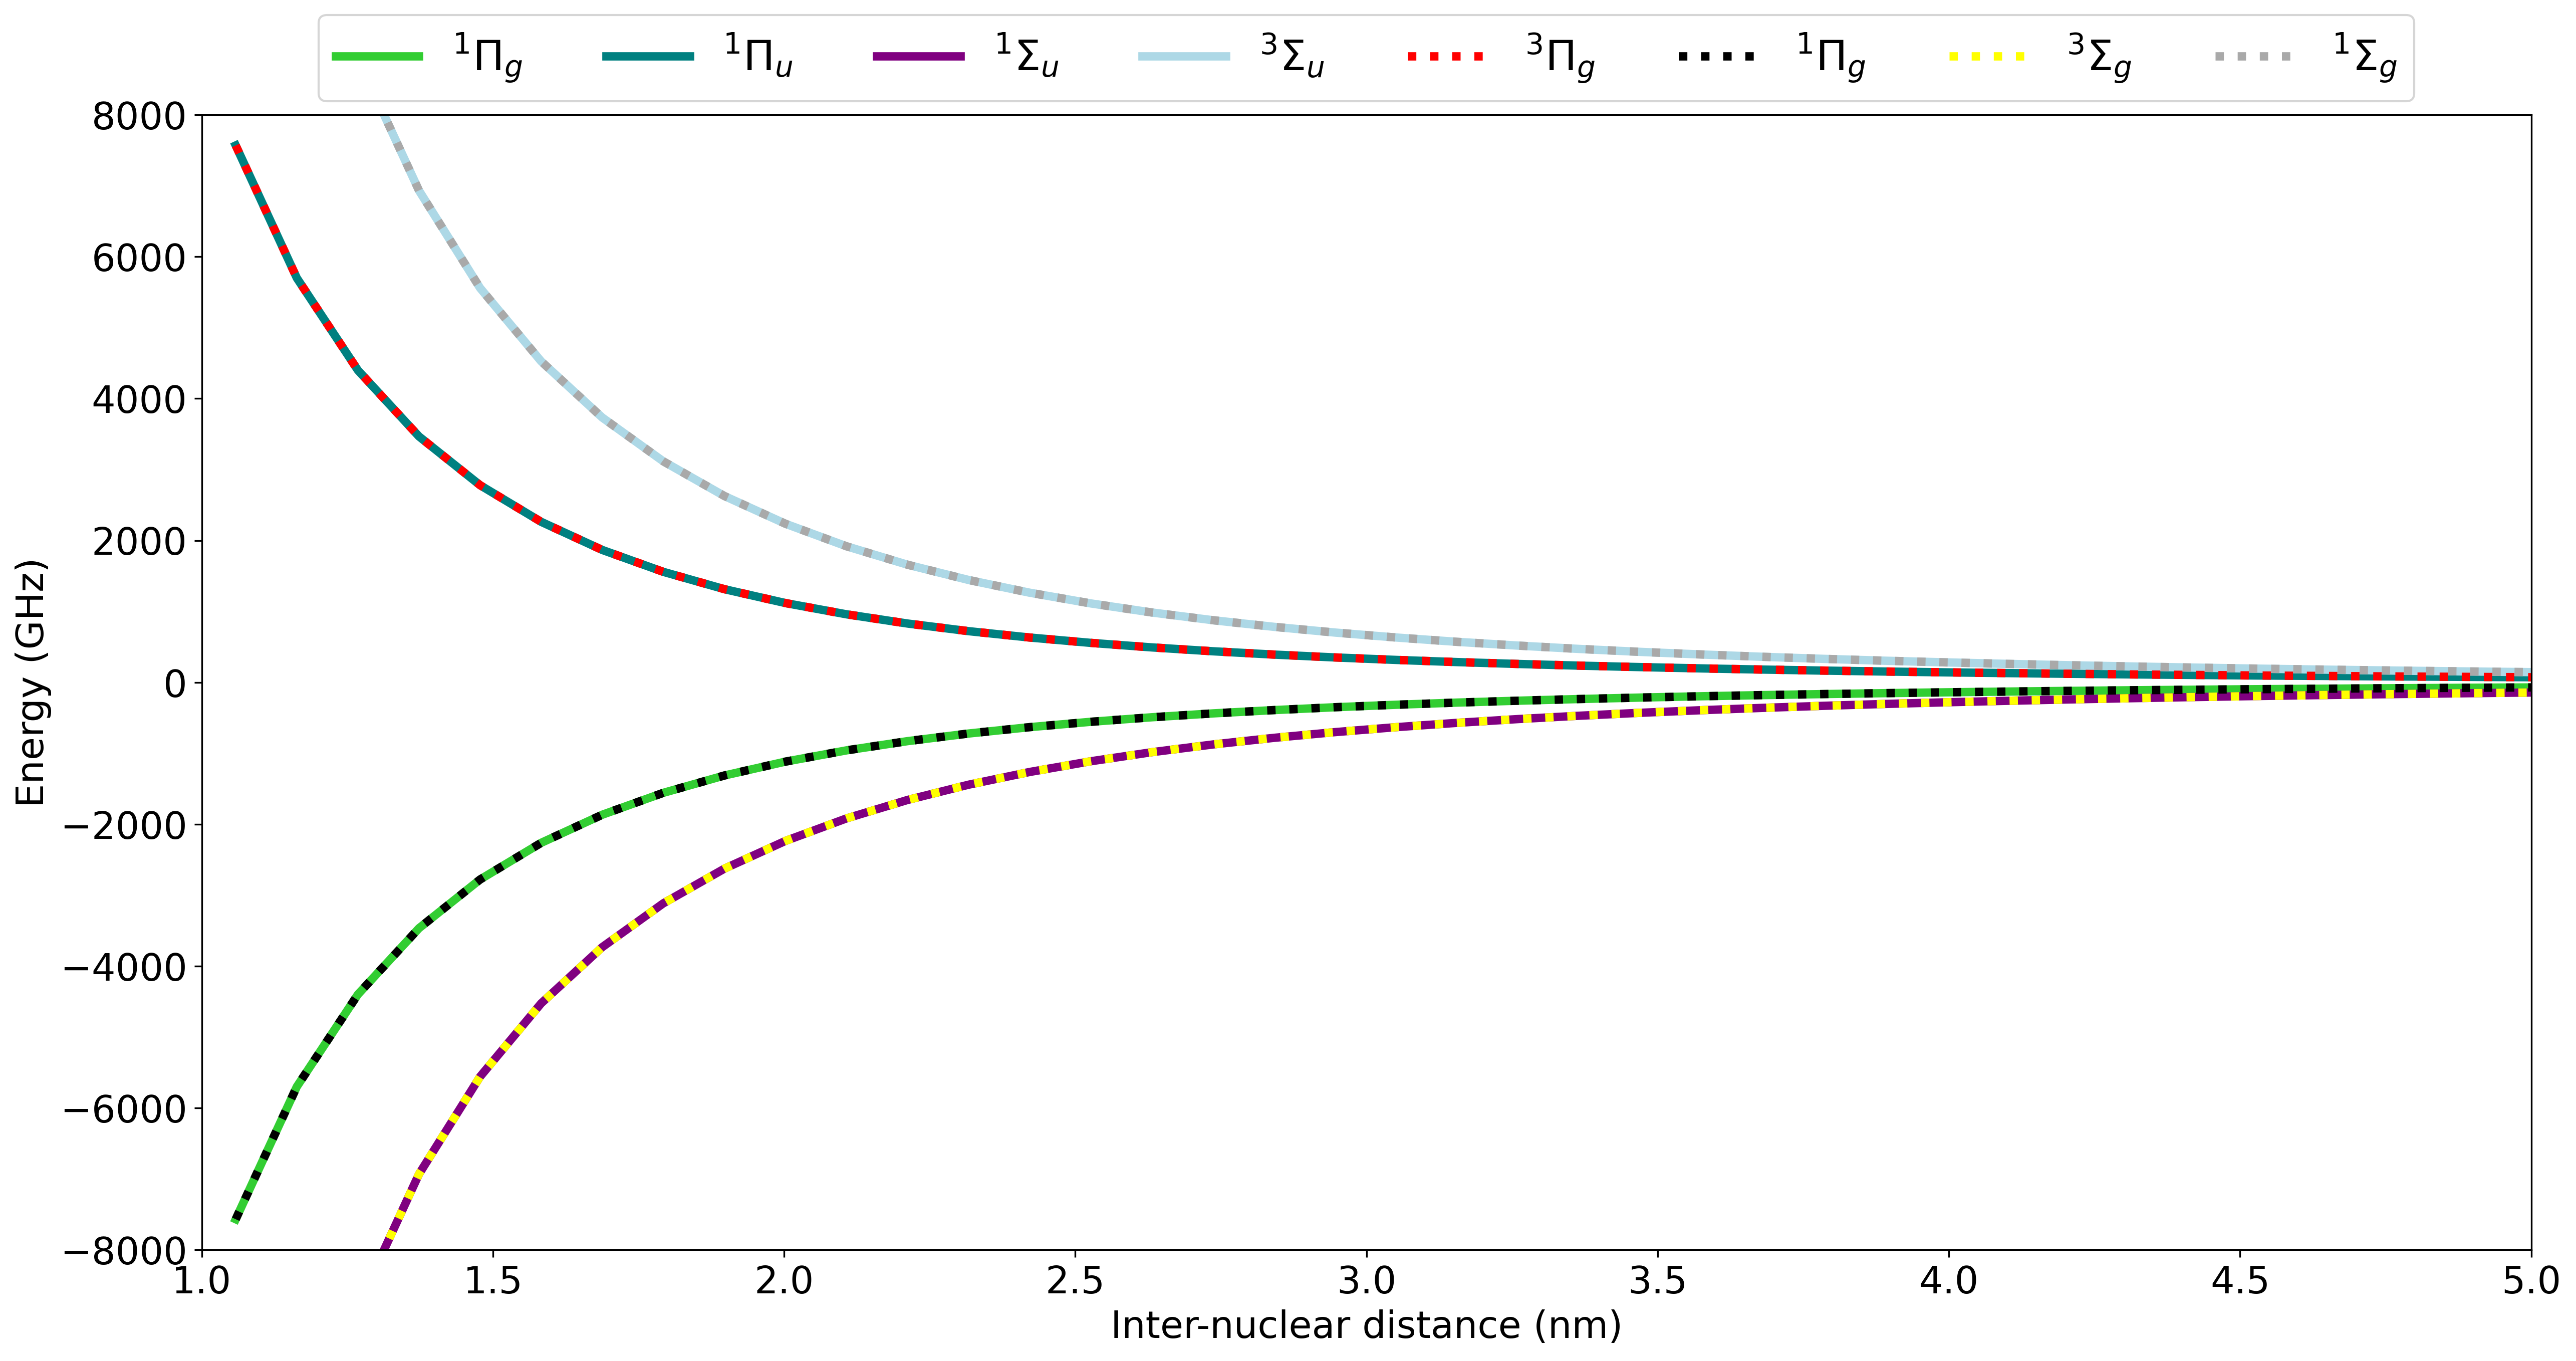

In [262]:
Rval = np.linspace( 20 * mc.a0, 2000 * mc.a0, 1000 )


# 3Pi_g, 1Pi_u
Htot1 = []
for a in Rval:
    H = [C_3_val/a**3*1e-9/mc.h]
    Htot1.append(H)

H1_e1 = Htot1

# 1Pi_g, 3Pi_u
Htot2 = []
for a in Rval:
    H = [-C_3_val/a**3*1e-9/mc.h]
    Htot2.append(H)
    
H2_e1 = Htot2  

# 3E_g, 1E_u
Htot3 = []
for a in Rval:
    H = [-2*C_3_val/a**3*1e-9/mc.h]
    Htot3.append(H);
    
H3_e1 = Htot3

# 1E_g, 3E_u
Htot4 = []
for a in Rval:
    H = [2*C_3_val/a**3*1e-9/mc.h]
    Htot4.append(H)
    
H4_e1 = Htot4
# print(H1_e1)
    
plt.figure(figsize=(20,10)) 
plt.xlabel("Inter-nuclear distance (nm)",fontsize=18)
plt.ylabel("Energy (GHz)",fontsize=18);
plt.ylim(-8000,8000)
plt.xlim(1,5)
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

mpl.rc('font', **font)

plt.plot(Rval*1e9,H2_e1,color = 'limegreen', label = r'${}^1 \Pi_g$')
plt.plot(Rval*1e9,H1_e1,color = 'teal',label = r'${}^1 \Pi_u$')  
plt.plot(Rval*1e9,H3_e1,color = 'purple', label = r'${}^1 \Sigma_u$')
plt.plot(Rval*1e9,H4_e1,color = 'lightblue', label = r'${}^3 \Sigma_u$')
plt.plot(Rval*1e9,H1_e1,color = 'red',linestyle = ':',label = r'${}^3 \Pi_g$') 
plt.plot(Rval*1e9,H2_e1,color = 'black',linestyle = ':', label = r'${}^1 \Pi_g$')
plt.plot(Rval*1e9,H3_e1,color = 'yellow',linestyle = ':', label = r'${}^3 \Sigma_g$') ### 0^g+ in Marks calc
plt.plot(Rval*1e9,H4_e1,color = 'darkgray',linestyle = ':', label = r'${}^1 \Sigma_g$')
# plt.plot(Rval*1e9,Htot9,color = 'lightgray', label = 'S + P ')
# plt.plot(Rval*1e9,Htot10,color = 'lightpink')
# plt.legend(loc='upper center', mode = "expand", ncol = 8)
plt.legend(ncol=9, fontsize=20, bbox_to_anchor=[0.0,0.8,1,0.5], loc='center')
# plt.margins(x=0)
# from matplotlib.pyplot import figure
# fig.savefig('FS.png', dpi=100)

### paper figure

C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_16468/1702241796.py:58: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_16468/1702241796.py:59: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')


Saving Fig...
Rendering Fig...


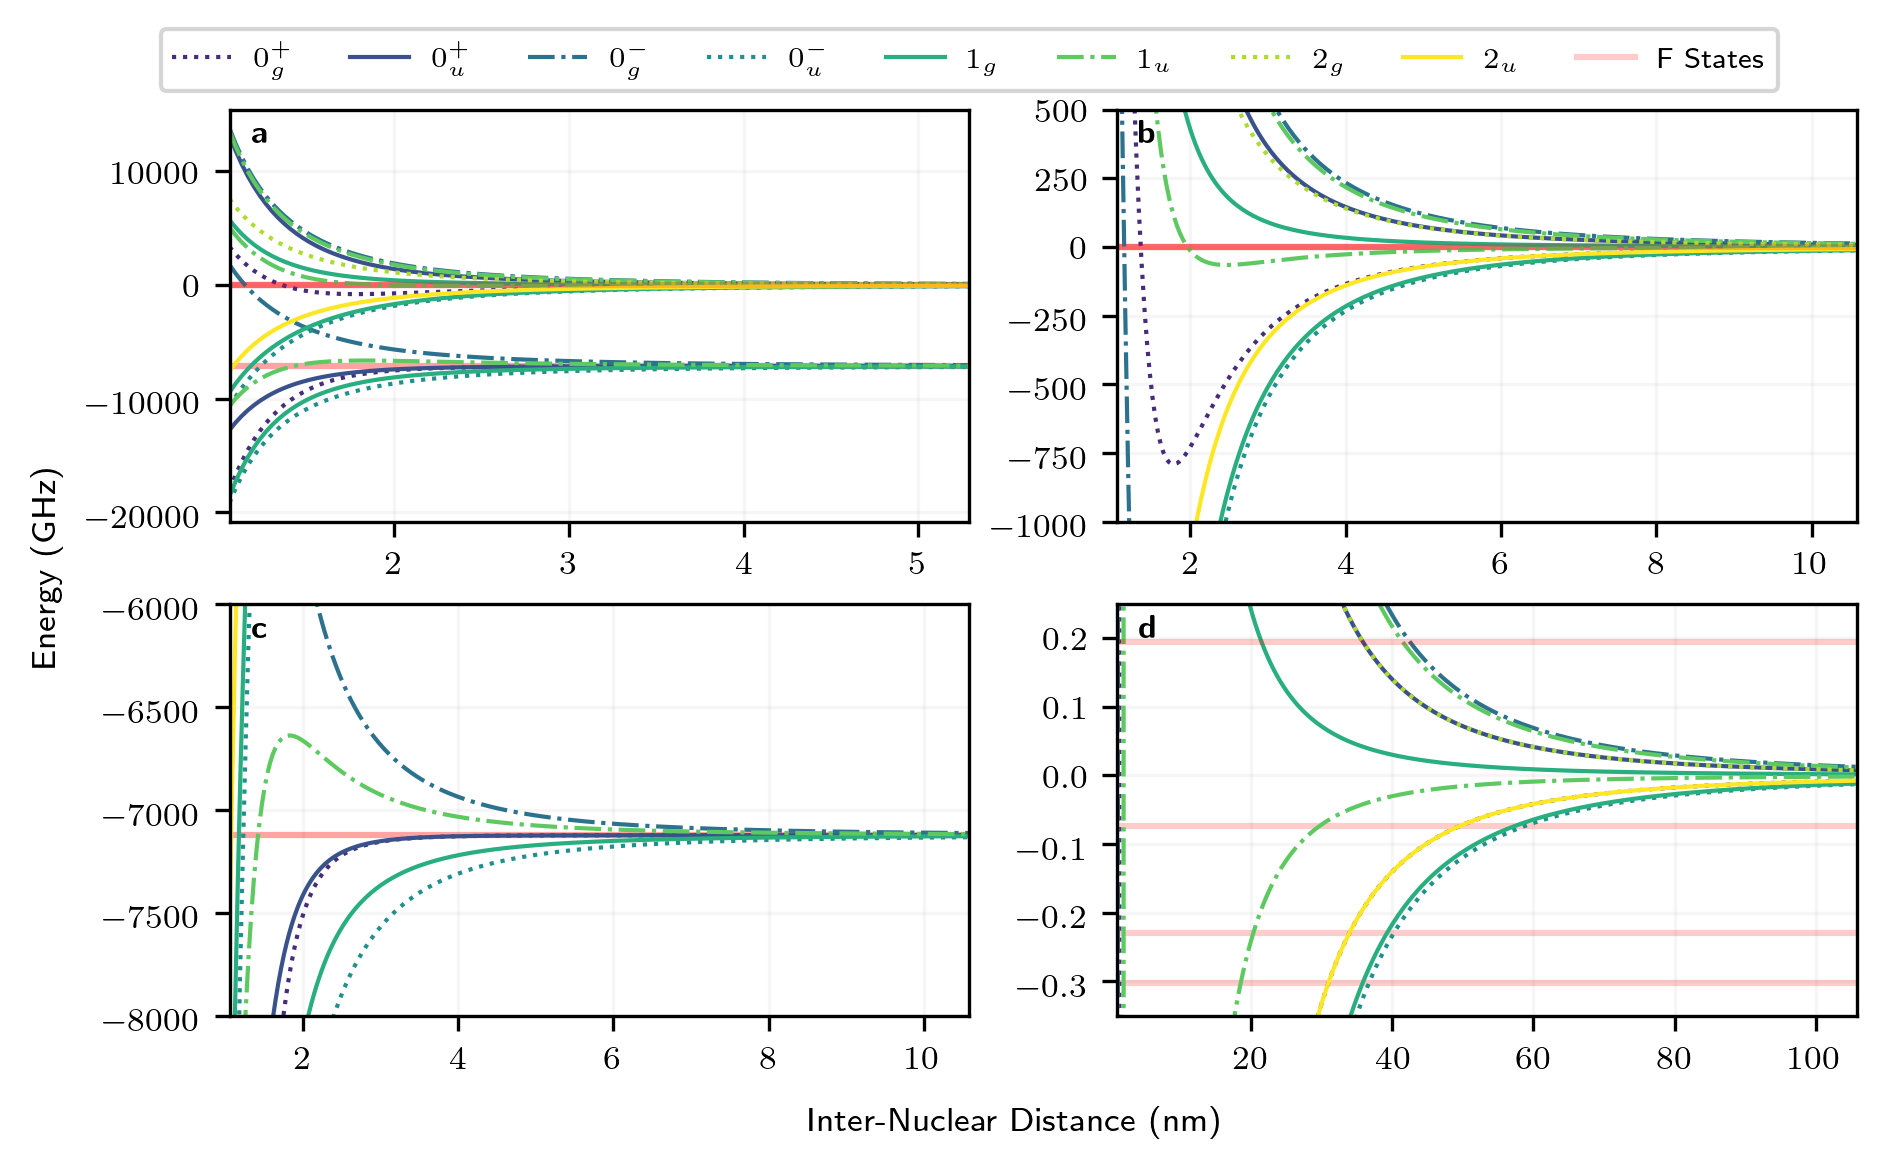

In [13]:
mpl.rcParams['font.size'] = 8
mpl.rcParams['text.usetex']=True
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}

for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for axnum, ax in enumerate(axs.flatten()):
    if True:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(label)==2:
            legLabel='$'+label[0]+'_'+label[1]+'$'
        if len(label)==3:
            legLabel='$'+label[0]+'^'+label[1]+'_'+label[2]+'$'
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=legLabel if lineNum == 0 else None, color=c_, linestyle=linestyle, lw=1)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')
    ax.text(0.03, 0.92,r'\textbf{'+['a','b','c','d'][axnum]+r'}', transform=ax.transAxes)

axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=9, fontsize=7, bbox_to_anchor=[0.5,0.87,1,0.5], loc='center')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[0,1].set_ylim(-1000, 500)
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[1,1].set_ylim(-0.35, 0.25)
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-8000, -6000);
#axs[0,0].axhline(-8000, linestyle=':',color='#AAAAAA')
#axs[0,0].axhline(-6000)

fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')
print('Saving Fig...')
#plt.savefig('Fine_Structure_Only.png', dpi=200)
print('Rendering Fig...')

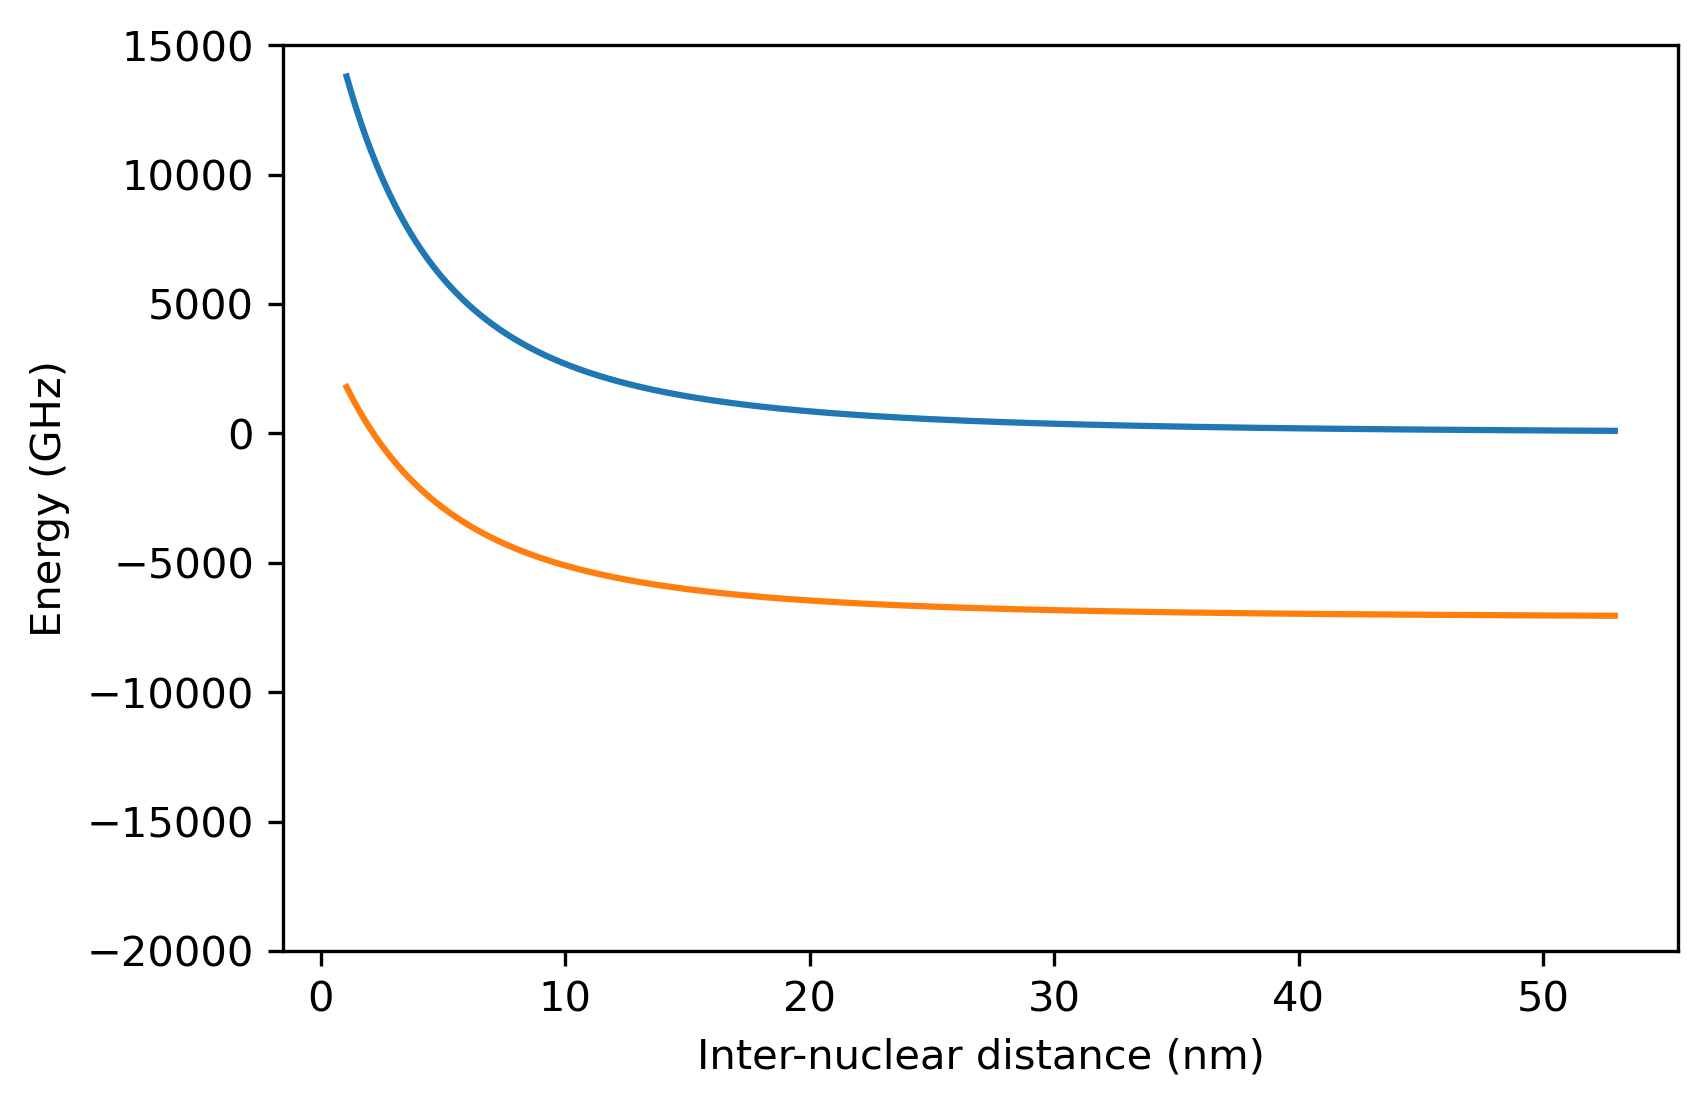

In [54]:
R_values = np.linspace(20 * mc.a0, 100 * mc.a0, 3000 )
eigen_values = []
for a in R_values:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_matrix = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_matrix)
    eigen_values.append(w*1e-9/mc.h)
    
plt.plot(Rval*1e9,eigen_values)
plt.xlabel("Inter-nuclear distance (nm)")
plt.ylabel("Energy (GHz)");
plt.ylim(-20000,15000)

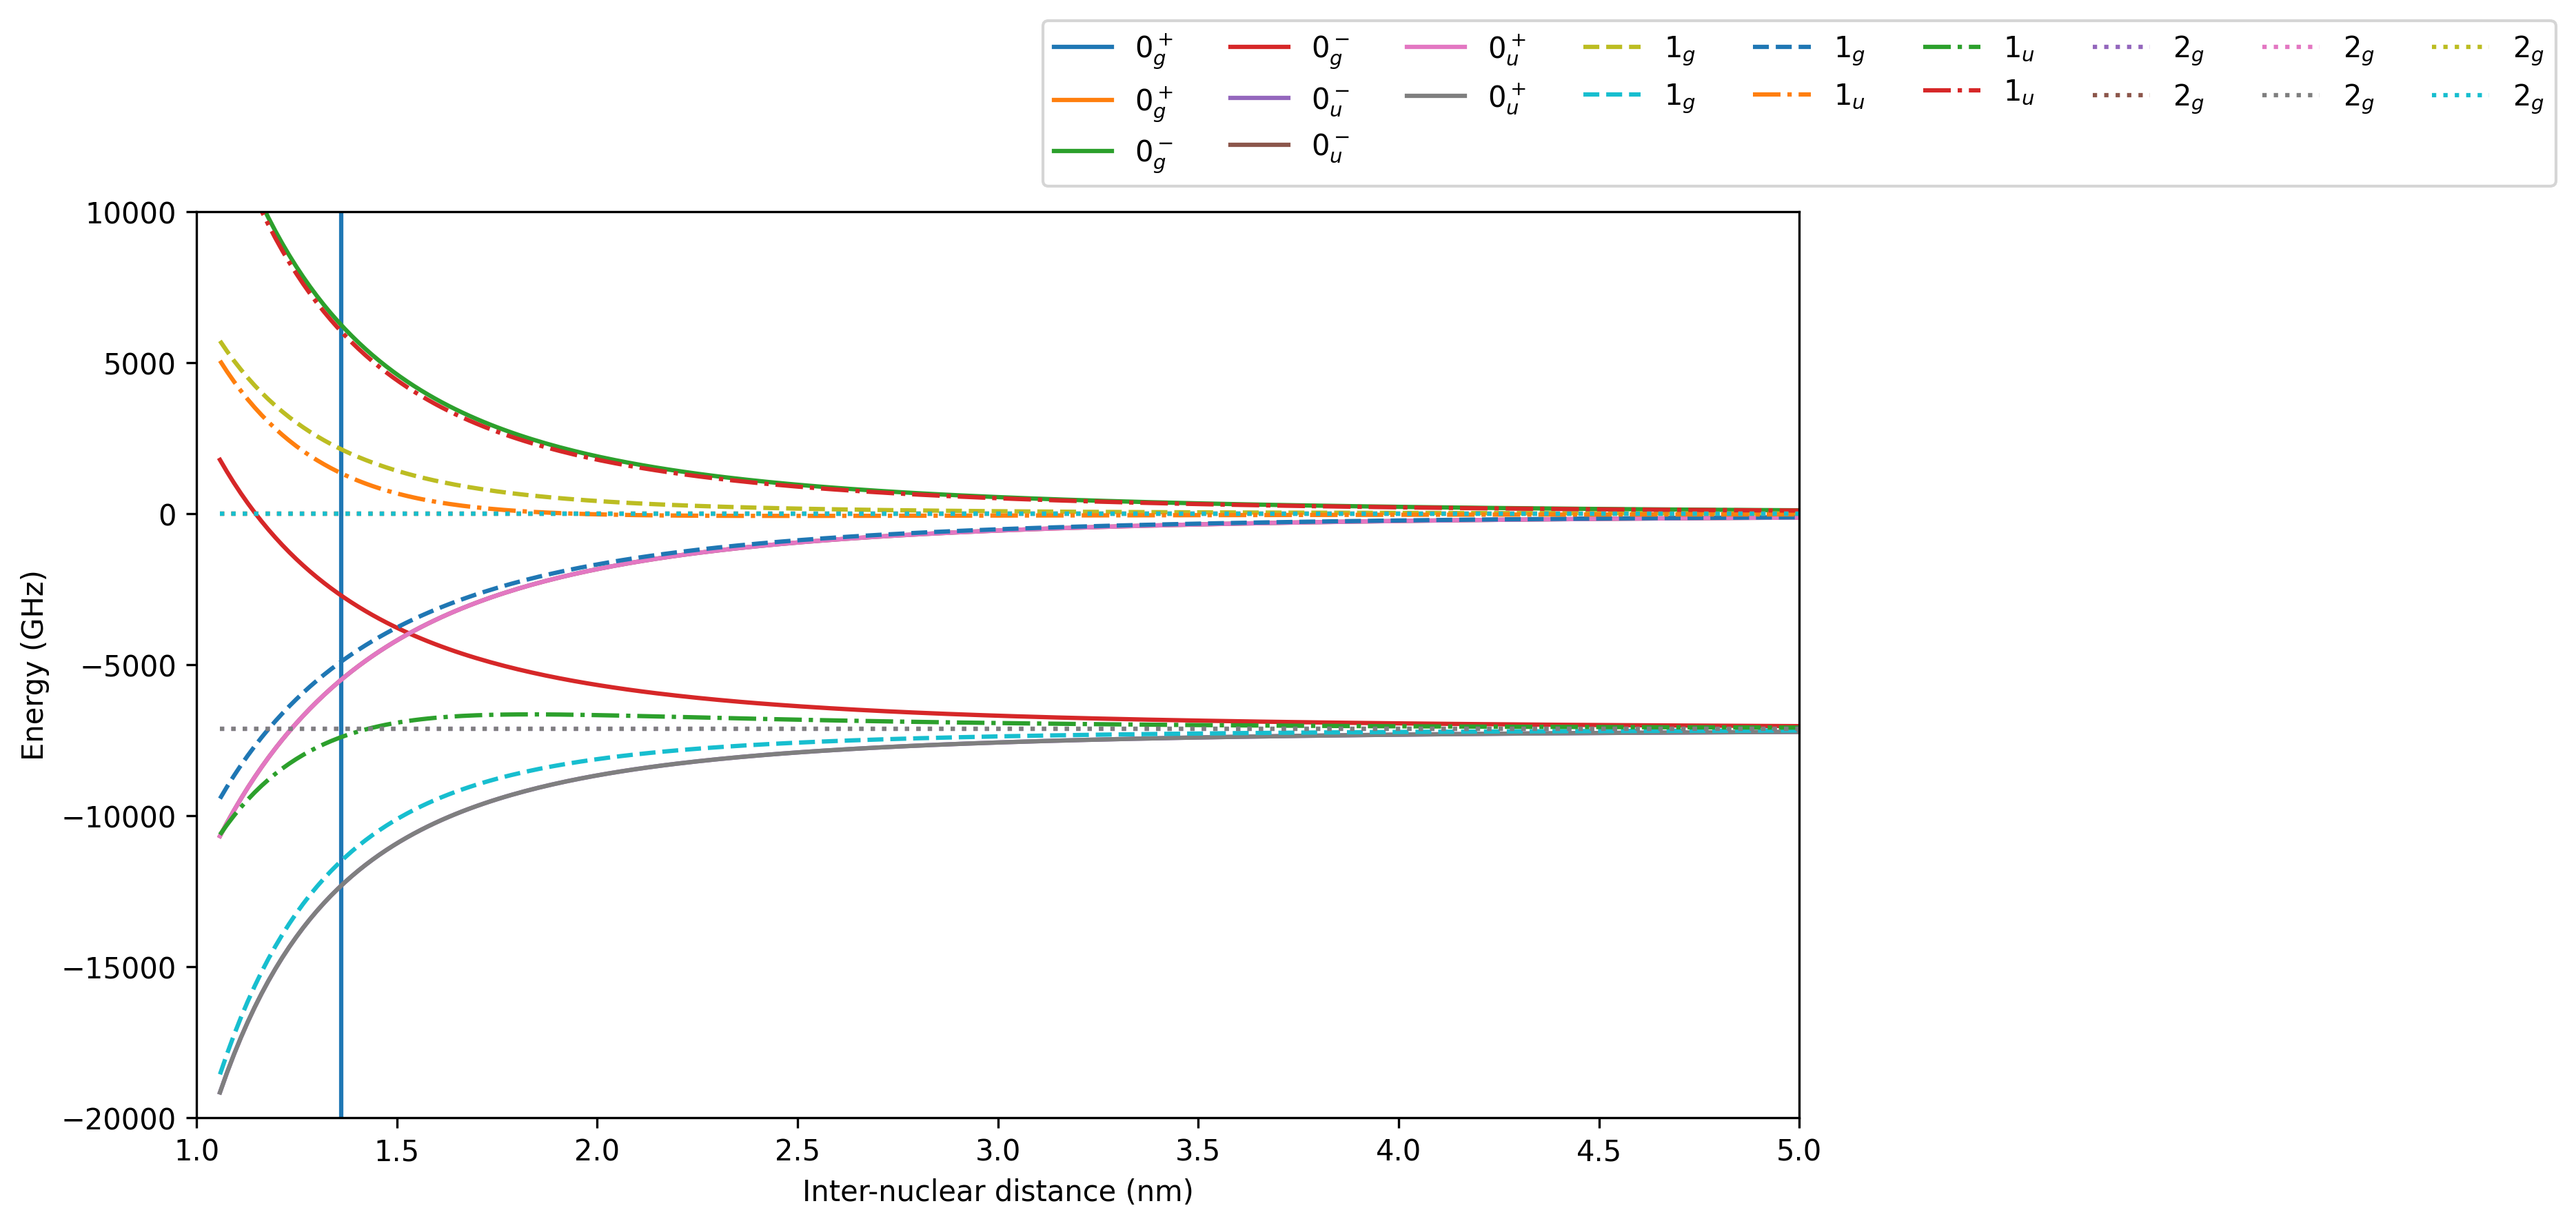

In [165]:
Rval = np.linspace( 20 * mc.a0, 1000 * mc.a0, 3000 )

Htot1 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))*1e20
    w,v = np.linalg.eig(H_mat)
    Htot1.append(w*1e-9/mc.h);
    
Htot2 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h)
    
Htot2 = []
for a in Rval:
    H = [C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3,np.sqrt(2)*DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h);
    
Htot3 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, -np.sqrt(2)*DeltaVal/3, -np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot3.append(w*1e-9/mc.h)

Htot4 = []
for a in Rval:
    H = [-C_3_val/a**3 - 2*DeltaVal/3, np.sqrt(2)*DeltaVal/3, np.sqrt(2)*DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot4.append(w*1e-9/mc.h)
    
Htot5 = []
for a in Rval:
    H = [C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3, -DeltaVal/3, -C_3_val/a**3 - DeltaVal/3, DeltaVal/3,\
         DeltaVal/3, DeltaVal/3,-2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(3,3))
    w,v = np.linalg.eig(H_mat)
    Htot5.append(w*1e-9/mc.h)
    
Htot6 = []
for a in Rval:
    H = [-C_3_val/a**3 - DeltaVal/3, -DeltaVal/3, DeltaVal/3, -DeltaVal/3, C_3_val/a**3 - DeltaVal/3, DeltaVal/3,\
         DeltaVal/3, DeltaVal/3,2*C_3_val/a**3 - DeltaVal/3]
    H_mat = np.reshape(H,(3,3))
    w,v = np.linalg.eig(H_mat)
    Htot6.append(w*1e-9/mc.h)
    
Htot7 = []
for a in Rval:
    H = [C_3_val/a**3]
    Htot7.append(w*1e-9/mc.h)
    
Htot8 = []
for a in Rval:
    H = [-C_3_val/a**3]
    Htot8.append(w*1e-9/mc.h)

plt.figure(figsize=(10,5.8)) 
plt.xlabel("Inter-nuclear distance (nm)")
plt.ylabel("Energy (GHz)");
plt.ylim(-20000,10000)
plt.xlim(1,5)

plt.plot(Rval*1e9,Htot1,label = r'$0_g^+$')
plt.plot(Rval*1e9,Htot2,label = r'$0_g^-$')
plt.plot(Rval*1e9,Htot3,label = r'$0_u^-$')
plt.plot(Rval*1e9,Htot4,label = r'$0_u^+$')
plt.plot(Rval*1e9,Htot5,label = r'$1_g$',linestyle = '--')
plt.plot(Rval*1e9,Htot6,label = r'$1_u$',linestyle = '-.')
plt.plot(Rval*1e9,Htot7,label = r'$2_g$',linestyle = ':')
plt.plot(Rval*1e9,Htot8,label = r'$2_g$',linestyle = ':')

plt.legend(ncol=9, fontsize=10, bbox_to_anchor=[0.5,0.87,1,0.5], loc='center')
plt.margins(x=0)
from matplotlib.pyplot import figure


### BO potentials

In [171]:
Rval = np.linspace( 20 * mc.a0, 1000 * mc.a0, 3 )

Htot1 = []
for a in Rval:
    H = [C_3_val/a**3, 0,0,-2*C_3_val/a**3]
    H_mat = np.reshape(H,(2,2))*1e20
    w,v = np.linalg.eig(H_mat)
    Htot1.append(w*1e-9/mc.h);
    
Htot2 = []
for a in Rval:
    H = [C_3_val/a**3, 0,0,2*C_3_val/a**3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h)
    
Htot2 = []
for a in Rval:
    H = [C_3_val/a**3, 0,0,2*C_3_val/a**3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot2.append(w*1e-9/mc.h);
    
Htot3 = []
for a in Rval:
    H = [-C_3_val/a**3, 0, 0,-2*C_3_val/a**3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot3.append(w*1e-9/mc.h)

Htot4 = []
for a in Rval:
    H = [-C_3_val/a**3, 0, 0,-2*C_3_val/a**3]
    H_mat = np.reshape(H,(2,2))
    w,v = np.linalg.eig(H_mat)
    Htot4.append(w*1e-9/mc.h)
    
Htot5 = []
for a in Rval:
    H = [C_3_val/a**3, 0, 0, 0, -C_3_val/a**3, 0,\
         0, 0,-2*C_3_val/a**3]
    H_mat = np.reshape(H,(3,3))
    w,v = np.linalg.eig(H_mat)
    Htot5.append(w*1e-9/mc.h)
    
Htot6 = []
for a in Rval:
    H = [-C_3_val/a**3, 0, 0,0, C_3_val/a**3, 0,\
         0, 0,2*C_3_val/a**3]
    H_mat = np.reshape(H,(3,3))
    w,v = np.linalg.eig(H_mat)
    Htot6.append(w*1e-9/mc.h)
    
Htot7 = []
for a in Rval:
    H = [C_3_val/a**3]
    Htot7.append(w*1e-9/mc.h)
    
Htot8 = []
for a in Rval:
    H = [-C_3_val/a**3]
    Htot8.append(w*1e-9/mc.h)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


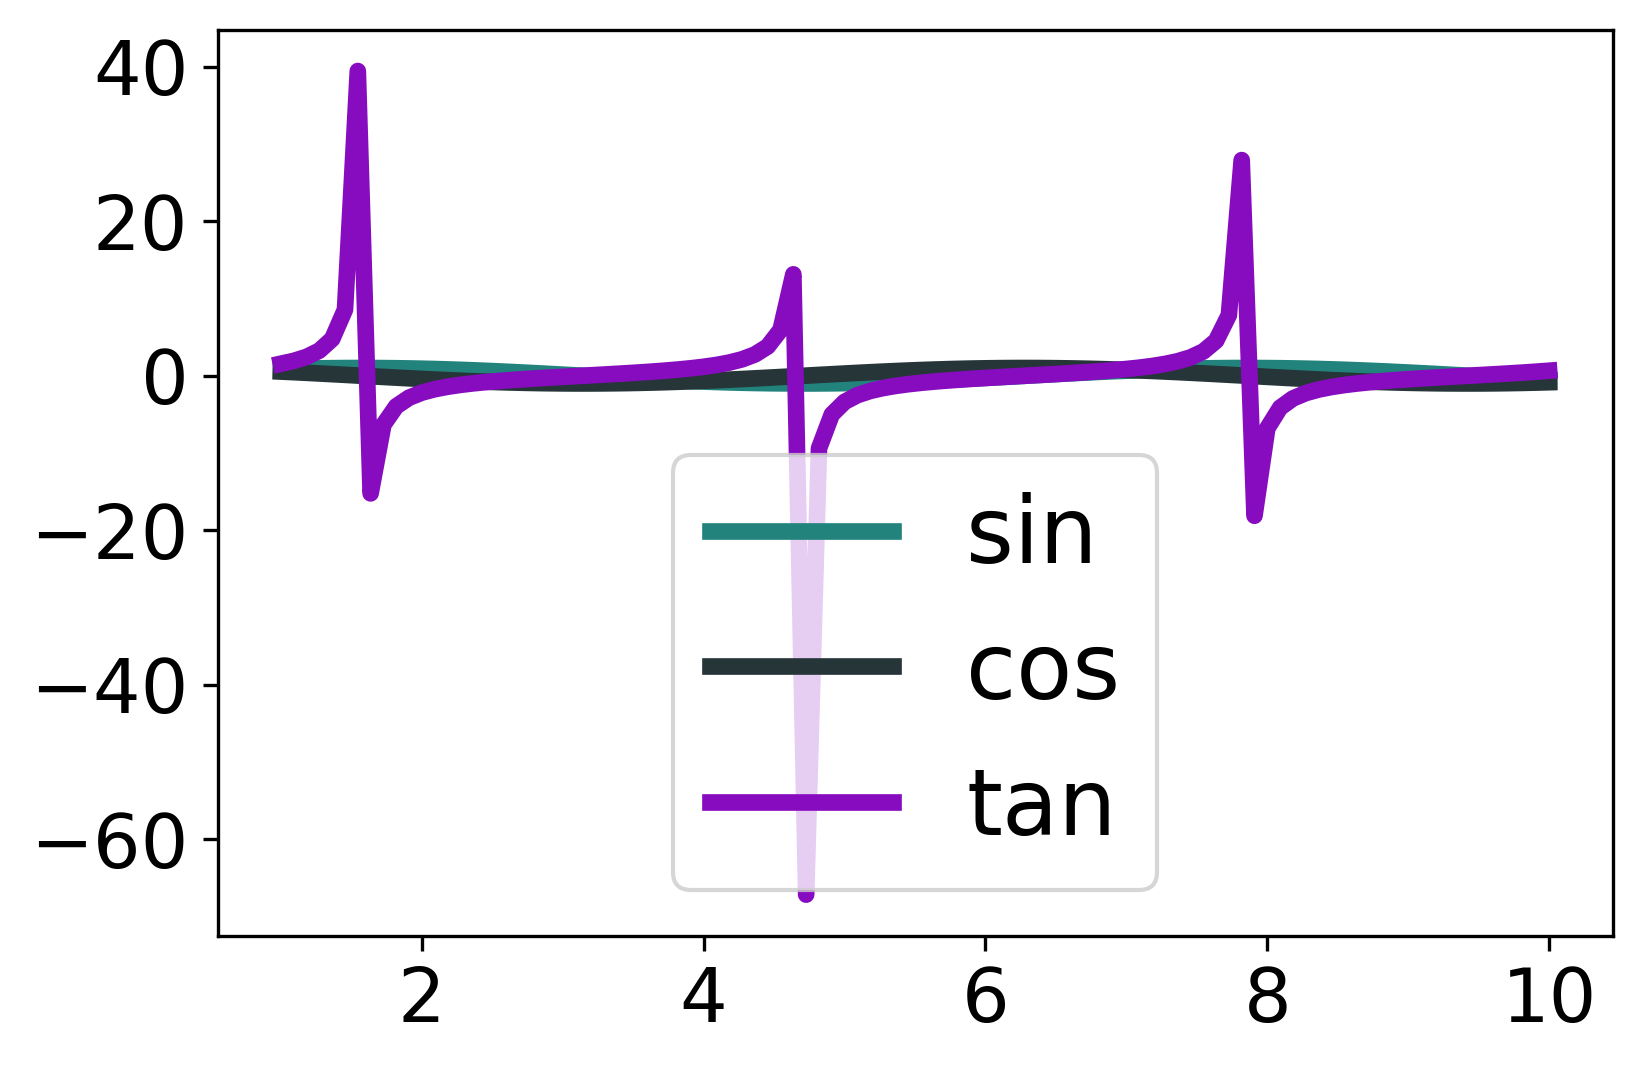

In [263]:
x = np.linspace(1,10,100)

f_1=[]
f_2=[]
f_3=[]
for i in x:
    f_1x = np.sin(i)
    f_2x=np.cos(i)
    f_3x=np.tan(i)
    f_1.append(f_1x)
    f_2.append(f_2x)
    f_3.append(f_3x)
    
funcs = [f_1,f_2,f_3]
# print(len(funcs))
# colors = ['red','blue','black']
labels = ['sin','cos','tan']
# plt.plot(x,funcs[1],color='red')
# from random import randint
# colors = []
# for i in range(len(funcs)):
#     colors.append('#%06X' % randint(0, 0xFFFFFF))
# print(colors)    
# for i in range(len(funcs)):
#     colors.append(plt.get_cmap('viridis'))
# print(colors)



for j in range(len(funcs)):
    plt.plot(x,funcs[j],color=colors[j],label=labels[j])
    plt.legend()



In [ ]:
plt.figure(figsize=(20,10)) 
plt.xlabel("Inter-nuclear distance (nm)")
plt.ylabel("Energy (GHz)");
plt.ylim(-20000,10000)
plt.xlim(1,5)

plt.plot(Rval*1e9,Htot1,label = r'$0_g^+$')
plt.plot(Rval*1e9,Htot2,label = r'$0_g^-$')
plt.plot(Rval*1e9,Htot3,label = r'$0_u^-$')
plt.plot(Rval*1e9,Htot4,label = r'$0_u^+$')
plt.plot(Rval*1e9,Htot5,label = r'$1_g$',linestyle = '--')
plt.plot(Rval*1e9,Htot6,label = r'$1_u$',linestyle = '-.')
plt.plot(Rval*1e9,Htot7,label = r'$2_g$',linestyle = ':')
plt.plot(Rval*1e9,Htot8,label = r'$2_g$',linestyle = ':')
# plt.legend(ncol=9, fontsize=10, bbox_to_anchor=[0.5,0.87,1,0.5], loc='upper left')
# plt.legend(bbox_to_anchor =(1.25, 1))
plt.margins(x=0)
from matplotlib.pyplot import figure



In [79]:
H = [1,2,3,4]
H_mat = np.reshape(H,(2,2))
print(H_mat)

[[1 2]
 [3 4]]


In [30]:
print(Htot+'i')

gi


In [ ]:
print